<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Propuesta Proyecto Final Grupo 5

Bogotá tiene un sistema educativo robusto. Uno de cada tres habitantes de la ciudad está vinculado al sistema educativo de la ciudad, que reúne casi 2,5 millones de personas de los cuales 1,4 millones son niños, niñas y adolescentes en los niveles preescolar, básica, secundaria y media (académica y técnica). Cerca de 743.000 de ellos son atendidos por el sector oficial y 425.000, por el sector privado. Las localidades con mayor matrícula son Suba, Kennedy y Bosa. La oferta del sector oficial está concentrada en las localidades de Bosa, Kennedy y Ciudad Bolívar, donde se atiende cerca del 25 % de estudiantes de la ciudad (Secretaría Distrital de Educación, 2024). 

Adicionalmente, considerando que Bogotá cuenta con una alta población infantil que representa el 23,6 % de los habitantes, con una marcada desigualdad socioeconómica, se hace evidente la necesidad depd.intervenciones específicas bajo un enfoque territorial, diferencial,pd.interseccional y de género. Sectores con índices significativos de pobreza y extrema pobreza, junto con la diversidad cultural y étnica, requieren enfoques diferenciados y pertinentes para abordar las particularidades de cada comunidad. 

En cuanto a instituciones, Bogotá cuenta con 1.962 colegios, 1.881 jardines, 134 instituciones de educación superior (IES) y 445 de educación para el trabajo y el desarrollo humano (IETDH). De los colegios, el sector oficial cuenta con 406 instituciones (371 de administración directa y 35 de administración contratada), el sector privado cuenta con 1.551 y existen 5 colegios oficiales con régimen especial. En la Ilustración 1   se encuentran georreferenciados los colegios del sector oficial, no oficial y las IES.   

Ilustración 1 – Colegios oficiales, No Oficiales & IES. 

![I1](figs/Ilustracion1.jpg)

Fuente:'SED con base en el DUE & IDECA. 

Al realizar un análisis de oferta y demanda para el sector oficial (en los niveles de preescolar a media), se encuentra que persiste un déficit de cupos en algunas zonas de la ciudad; especialmente UPZ de las localidades de Suba, Kennedy, Bosa, Antonio Nariño. Ciudad Bolívar y Usme. Este déficit de cupos es significativo para el nivel de preescolar en las UPZ El Rincón, Tibabuyes y Patio Bonito.   

Ilustración 2- Déficit/ Superávit del Sector Oficial por Nivel Educativo. 

![I2](figs/Ilustracion2.png)

 

Fuente:'Estudio de Insuficiencia y Limitaciones 2023 (Secretaría de Educación del Distrito, 2022) 

La gestión de la cobertura educativa gira en torno a la modernización del proceso para la asignación eficiente de cupos educativos en Bogotá siendo una prioridad para garantizar que todas y todos los estudiantes tengan acceso a una educación de calidad. Mejorar y optimizar el proceso de asignación de cupos y la reducción de las barreras que limitan el acceso de los niños, niñas, adolescentes y jóvenes al sistema educativo y, de esta manera, promover la igualdad y equidad de oportunidades. 

In [144]:
# data analysis libs
import pandas as pd
import numpy as np
import session_info
import datetime
import pickle
pd.set_option('display.max_columns', None)

# data viz libs
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Análisis descriptivo de datos

### 1.1 Carga de datos

Para este proyecto se cuenta con 3 bases de datos.

* Información de estudiantespd.interesados en la inscripción a un colegio distrital, que llamaremos `inscripciones`.
* Puntajes de pruebas saber 3,5,9,11, que llamaremos `icfes`.
* Datos de capacidad y área por colegios, que llamaremos `capacidad`.

In [182]:
# Carga de datos de inscripciones
dict_inscripciones = pickle.load(open("dict_inscripciones.p", "rb"))
col_names = [col_name for col_name in dict_inscripciones.keys()]
inscripciones = pd.read_excel('data/9103Z1-Inscripciones2024-DatosGenerales-20240719.xlsx'
                              , sheet_name = "Inscripcion2024")
inscripciones = inscripciones[col_names]
inscripciones = inscripciones.astype(dict_inscripciones)
inscripciones['ASIGNADO_DANE_SEDE'] = inscripciones['ASIGNADO_DANE_SEDE'].astype('str').str.replace('.0', '')

In [239]:
# Carga de datos ICFES
icfes = pd.read_excel('data/ActualizaSABER_11_2023_Def_Rdsl.xlsx', sheet_name = 'PROMEDIOS_NIVELES_IE')
icfes = icfes[['AÑO', 'CODIGODANE','P_Puntaje_Global','EVALUADOS']]
icfes = icfes.rename(columns={'CODIGODANE':'ASIGNADO_DANE_SEDE','P_Puntaje_Global':'Puntaje ICFES 11', 'EVALUADOS':'Evaluados ICFES 11'})
icfes['ASIGNADO_DANE_SEDE'] = icfes['ASIGNADO_DANE_SEDE'].astype('str').str.replace('.0', '')
icfes = icfes.groupby('ASIGNADO_DANE_SEDE')[['Puntaje ICFES 11', 'Evaluados ICFES 11']].mean().reset_index()

In [237]:
# Carga de datos capacidad instalada
capacidad = pd.read_excel('data/VARIABLES CAPACIDAD INSTALADA mod.xlsx', sheet_name = 'MATRIZ GENERAL')
capacidad = capacidad[['CODIGO DANE ','CAPACIDAD INSTALADA - PREESCOLAR', 'CAPACIDAD INSTALADA - 1-11',
       'CAPACIDAD INSTALADA - Total', 'AULAS  Preescolar', 'AULAS  1-11',
       'ÁREAS - PREESCOLAR', 'ÁREAS   1-11']]
capacidad = capacidad.dropna(subset=['CODIGO DANE '])
capacidad['CODIGO DANE '] = capacidad['CODIGO DANE '].dropna().astype('str').str.replace('.0', '')
capacidad = capacidad.rename(columns={'CODIGO DANE ': 'ASIGNADO_DANE_SEDE'})

### 1.2 Consolidacion Datos

En esta sección consolidamos los datos en un único dataframe

In [628]:
df = inscripciones.merge(icfes
                        , how= 'left'
                        , on = 'ASIGNADO_DANE_SEDE').merge(capacidad
                                                           , on = 'ASIGNADO_DANE_SEDE'
                                                           , how='left')

df['ASIGNADO_DANE_SEDE'].insa().sum()

AttributeError: 'Series' object has no attribute 'insa'

### 1.3 Columnas calculas

In [606]:
## Columnas calculadas
# Edad Inscritos
df['EDAD_INR'] = (df['FECHA_INSCRITO'] -df['INR_NACI_FECHA']).apply(lambda x: x.days//365.25)
# Decil en el puntaje del ICFES promedio del colegio
df['Decil ICFES'] = (pd.qcut(df['Puntaje ICFES 11'], 10, labels=['1st Decile',
                                                                    '2nd Decile',
                                                                    '3rd Decile',
                                                                    '4th Decile',
                                                                    '5th Decile',
                                                                    '6th Decile',
                                                                    '7th Decile',
                                                                    '8th Decile',
                                                                    '9th Decile',
                                                                    '10th Decile'])) 
# Ranking ICFES
rankings_icfes = df[['ASIGNADO_DANE_SEDE', 'Puntaje ICFES 11']].drop_duplicates().set_index('ASIGNADO_DANE_SEDE').rank(ascending=False).rename(columns = {'Puntaje ICFES 11': 'Ranking ICFES'}).reset_index()
df = df.merge(rankings_icfes, how = 'left', on = 'ASIGNADO_DANE_SEDE')

In [607]:
# Demanda vs Capacidad
num = df['ASIGNADO_DANE_SEDE'].value_counts().reset_index().rename(columns = {'count': 'Num'})
den = df[['ASIGNADO_DANE_SEDE', 'CAPACIDAD INSTALADA - Total']].drop_duplicates().set_index('ASIGNADO_DANE_SEDE').apply(np.ceil).reset_index().rename(columns = {'CAPACIDAD INSTALADA - Total': 'Den'})
cap_vs_demanda = num.merge(den, on = 'ASIGNADO_DANE_SEDE', how = 'left')
cap_vs_demanda['DEMANDA VS CAPACIDAD %'] = cap_vs_demanda['Num'] / cap_vs_demanda['Den'] * 100
cap_vs_demanda = cap_vs_demanda.drop(columns=['Num', 'Den'])
df = df.merge(cap_vs_demanda, how = 'left', on = 'ASIGNADO_DANE_SEDE')
df.replace([np.inf, -np.inf], np.nan, inplace = True)

In [608]:
df.iloc[:3, -4:]

EDAD_INR Decil ICFES  Ranking ICFES  DEMANDA VS CAPACIDAD %
0       4.0  4th Decile          221.0               36.038961
1       6.0  3rd Decile          274.0               17.726658
2       8.0  3rd Decile          244.0               39.191291

### 1.4 Análisis descriptivo de los datos

En esta sección iniciamos con el análisis descriptivos de los datos

#### 1.4 Análisis univariado

In [614]:
def topn_bars(col, n):
    test_ = df[col].value_counts().reset_index()
    test_.loc[:n,'In top n?'] = 1
    test_ = test_.fillna(0)
    otros_ = test_[test_['In top n?'] == 0]['count'].sum()
    data_ = pd.concat([test_.iloc[:n], pd.DataFrame({col: ['Otros'], 'count': [otros_], 'In top n?': [0]})], ignore_index=True)
    
    ax = sns.barplot( data = data_, x= col, y = 'count')    
    ax.bar_label(container=ax.containers[0])
    plt.xticks(rotation = 45, fontsize = 8, ha= 'right')
    ax.set(title = f'Top {n} barras para {col}')
    plt.show()

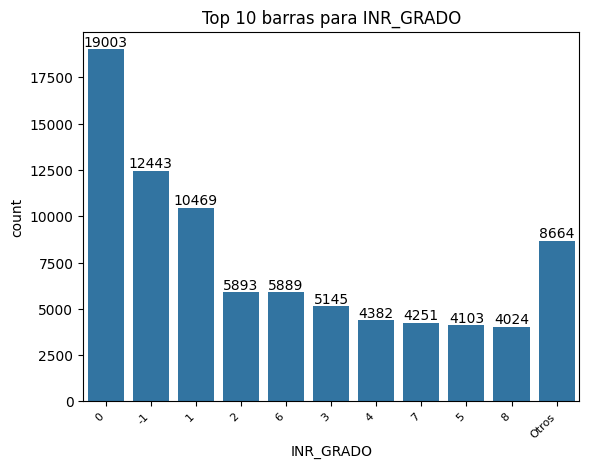

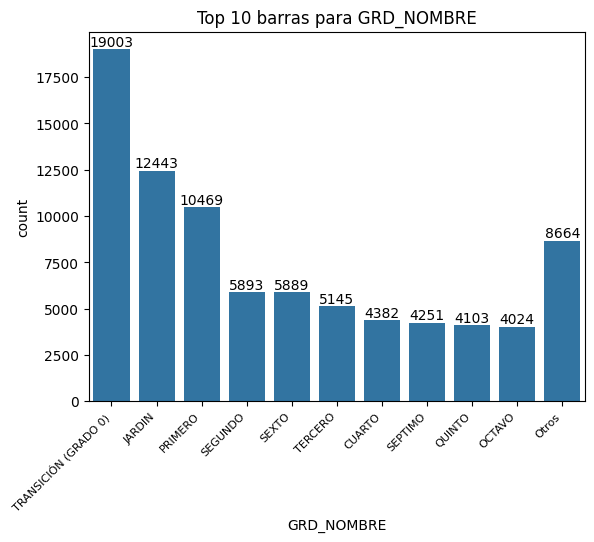

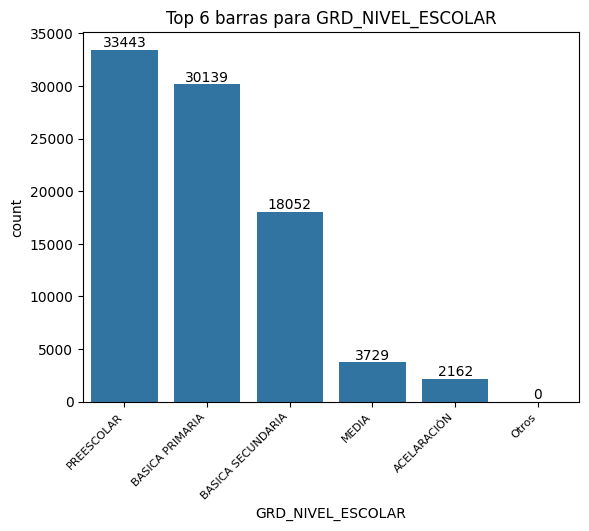

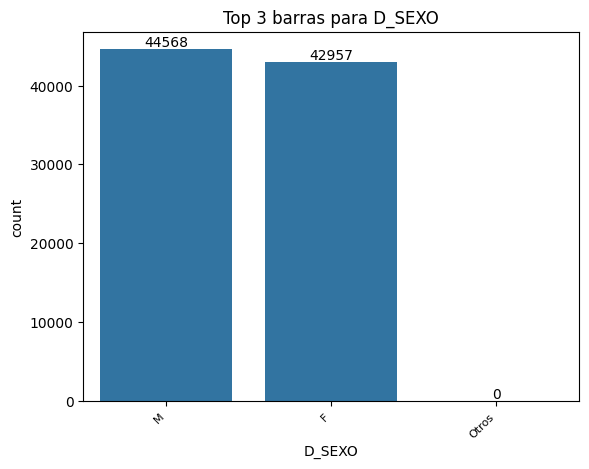

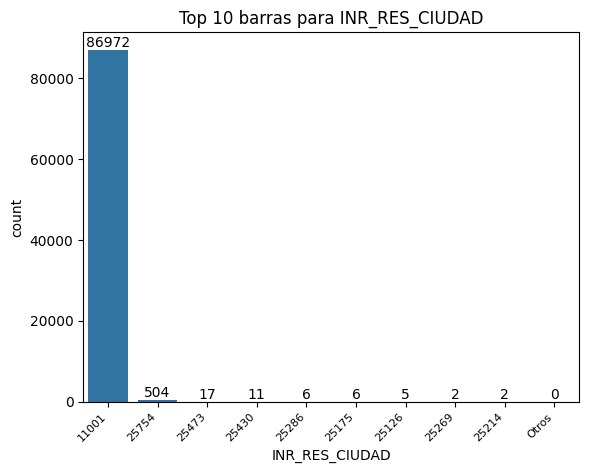

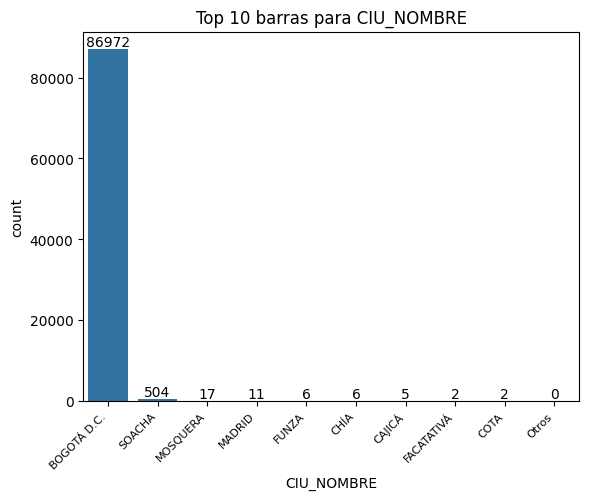

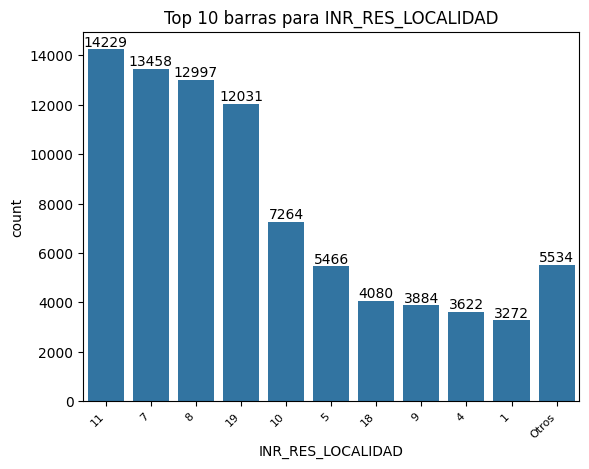

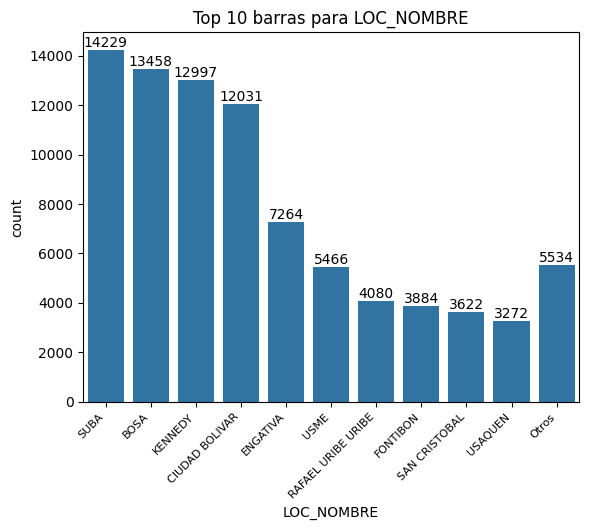

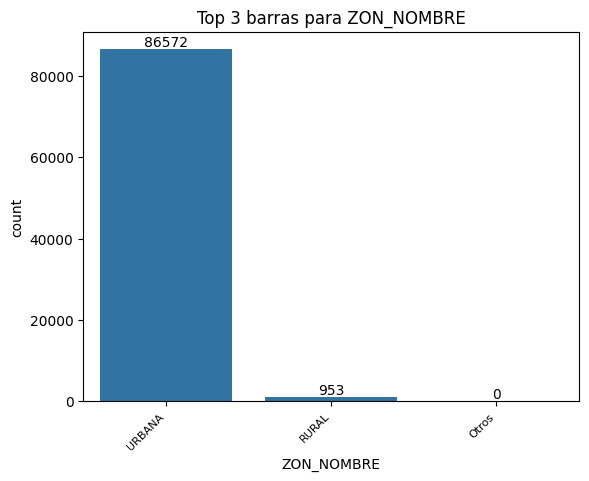

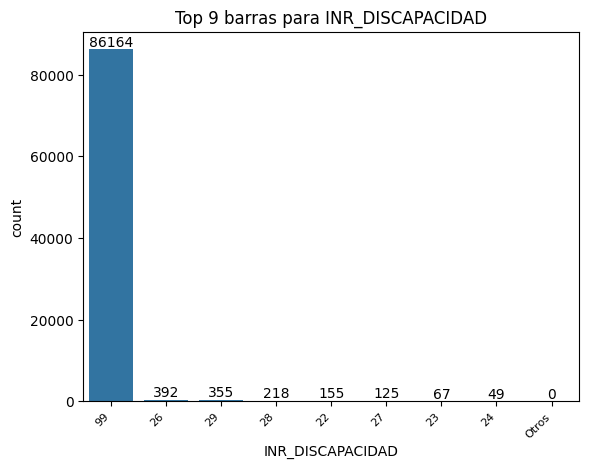

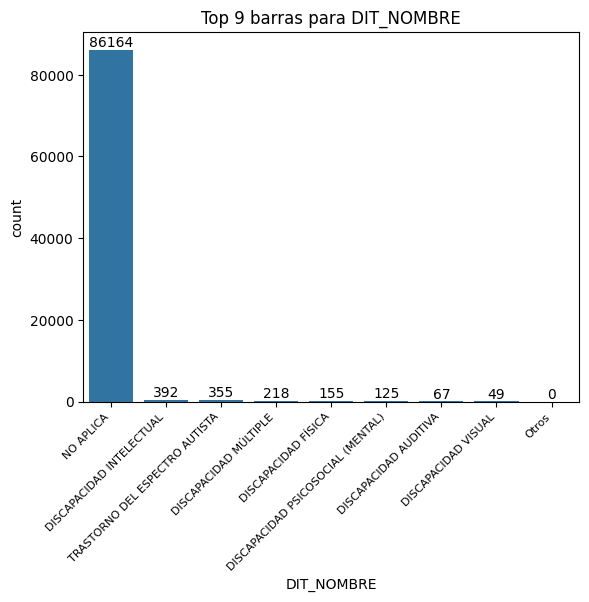

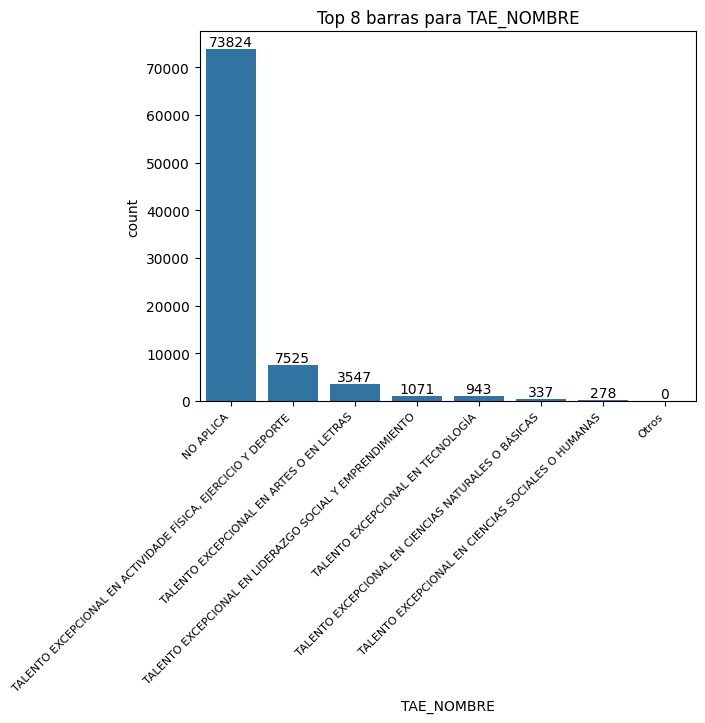

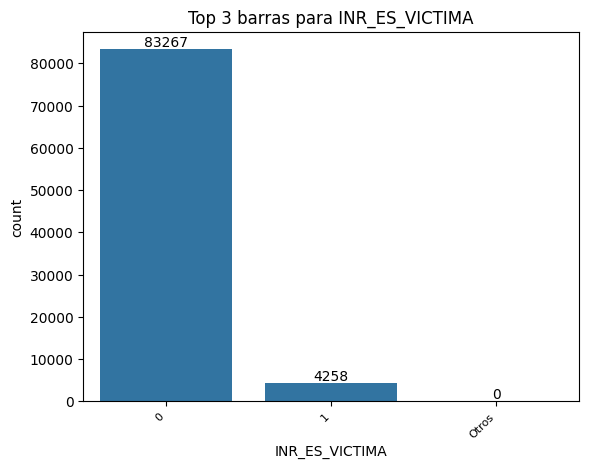

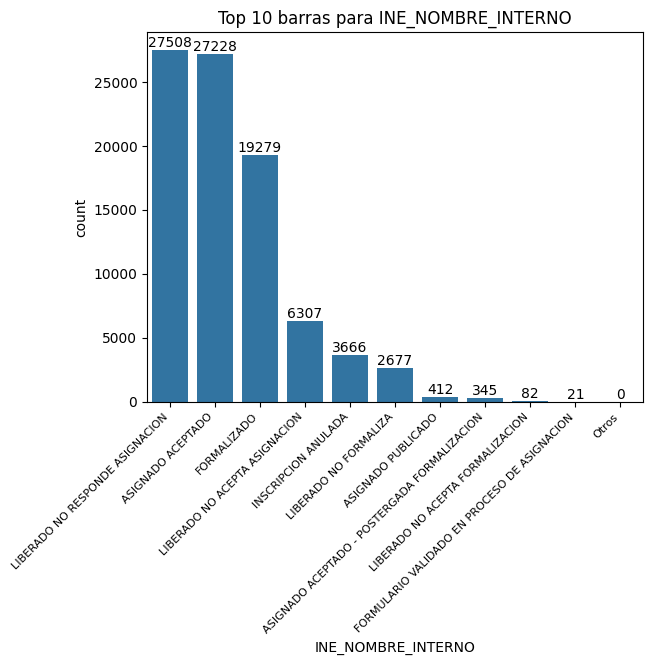

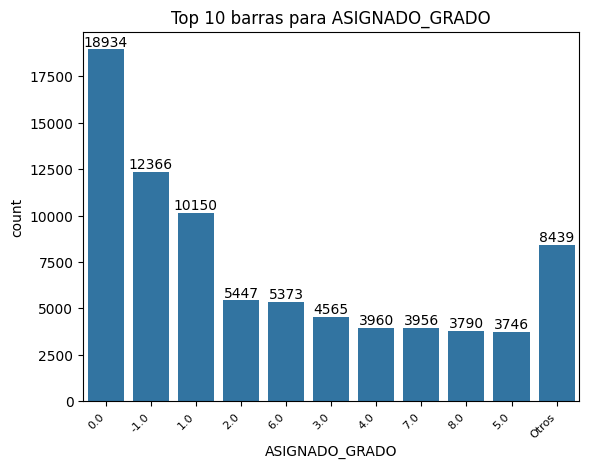

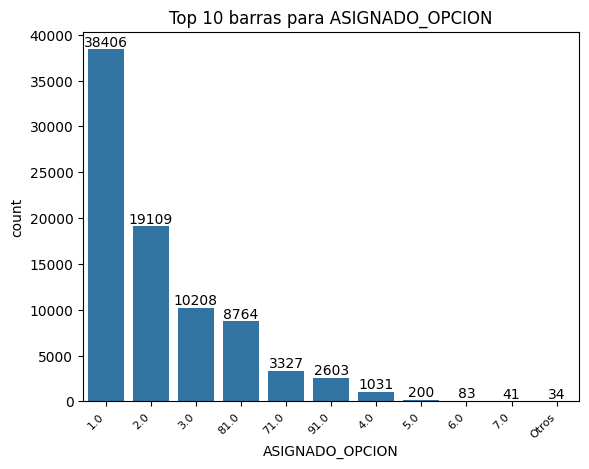

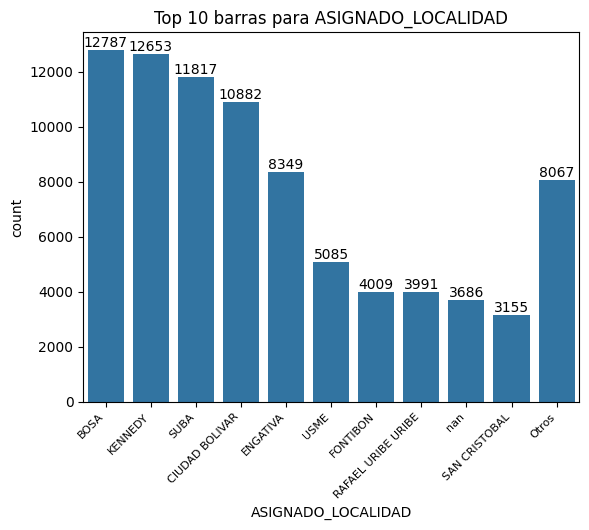

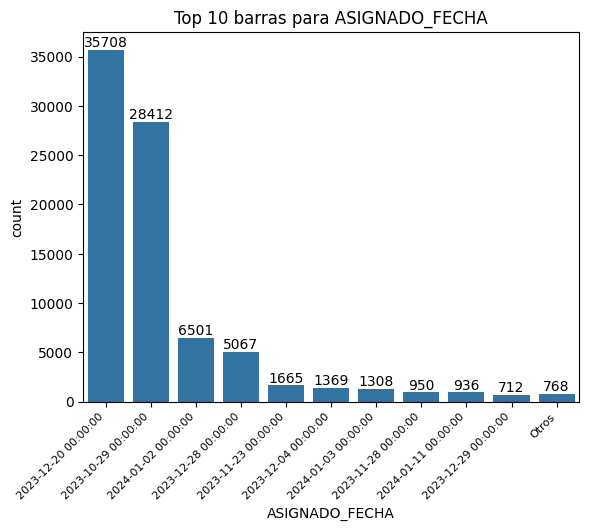

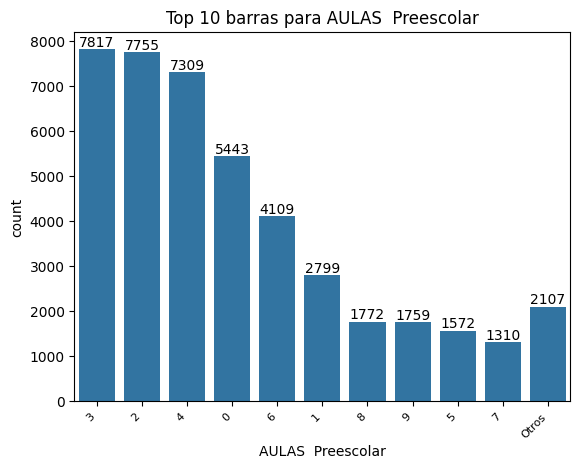

In [616]:
for col in df.columns:
    if len(df[col].unique()) < 25:
        try:
            topn_bars(col, min(len(df[col].unique())+1,10))
        except:
            continue



#### 1.5 Análisis Bivariado

#### 1.5.1 Análisis bivariado categóricas vs Puntaje ICFES

In [399]:
def categories_vs_y(col,n, y):
    df2 = df[~df[y].isna()]
    test = df2[col].value_counts().reset_index()
    test = test.iloc[:n]
    test[col] = test[col].astype(df2[col].dtype)
    data2 = df2[[col,y]].merge(test, on = col , how = 'left')
    data2[col] = data2[col].astype('object')
    data2.loc[data2['count'].isna(), col] = 'Otros'
    plt.figure(figsize=(10,5))
    ax = sns.violinplot( data = data2, x= col, y = y, inner = None, saturation = 0.5)
    sns.boxplot(data=data2, x= col, y=y, saturation=0.5, width=0.4,
                hue = col, legend = False, boxprops={'zorder': 2}, ax=ax)
    plt.title(f'{y} vs {col} considering only top {n} categories', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel(f'{y}', fontsize=12)
    plt.xticks(rotation = 45, ha='right')
    plt.show()

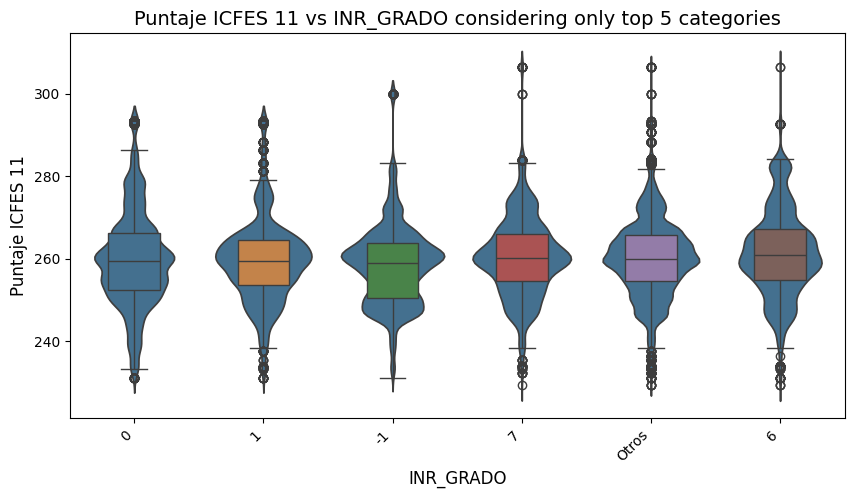

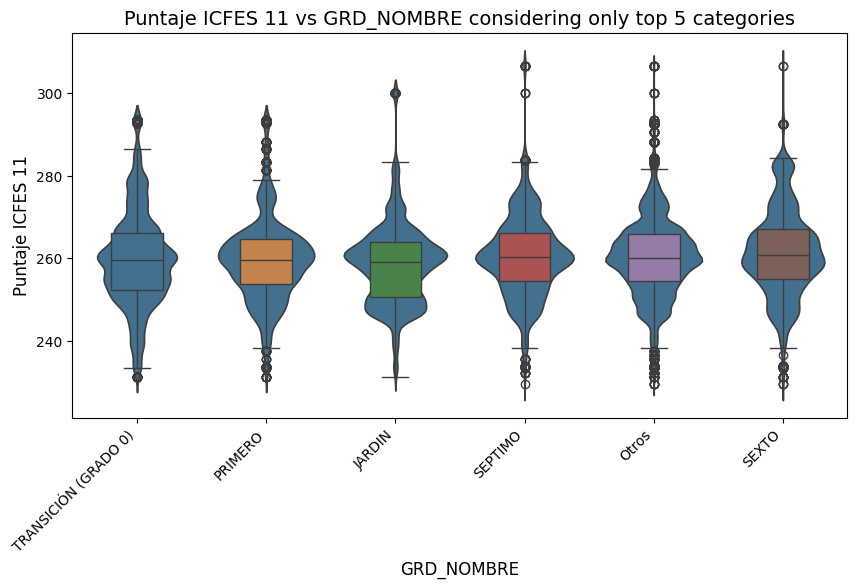

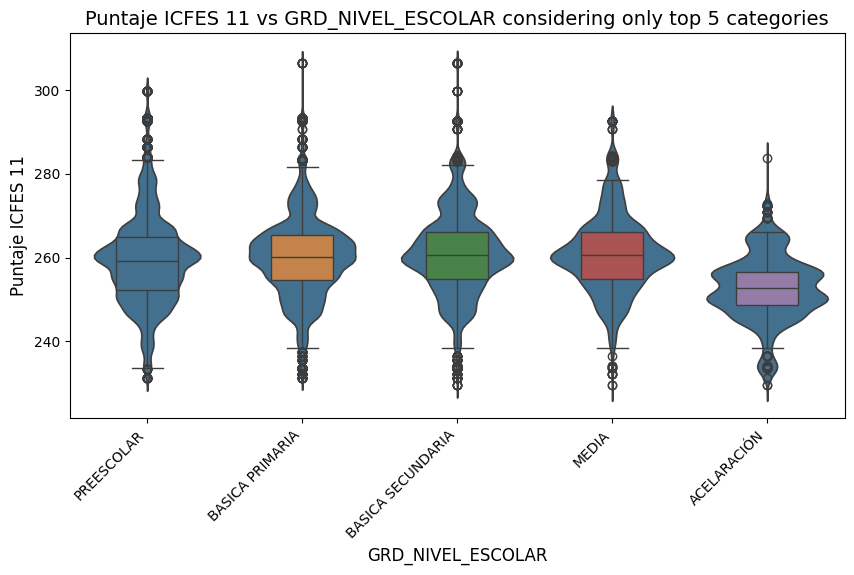

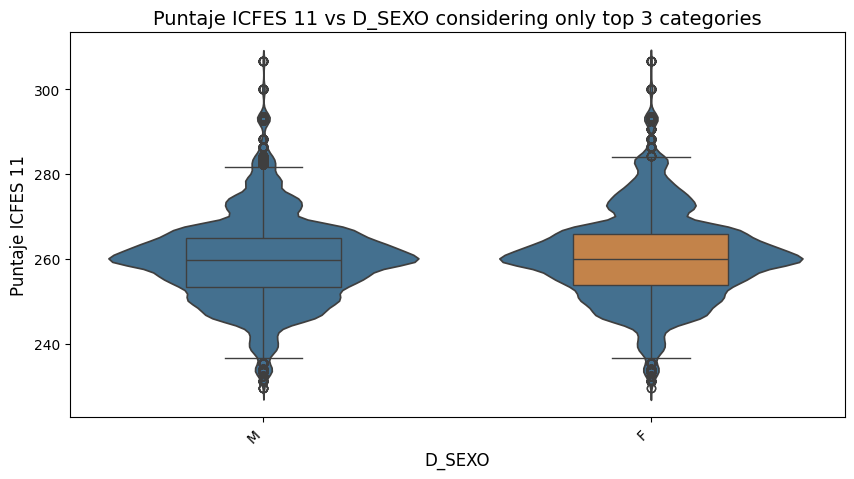

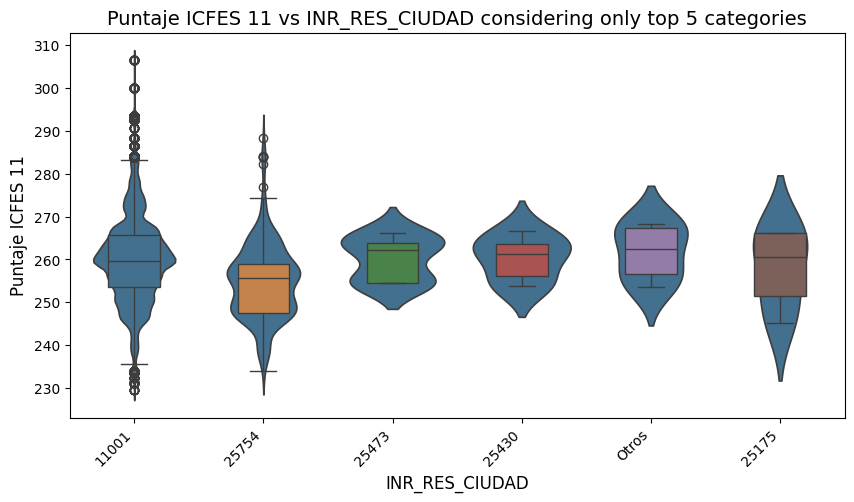

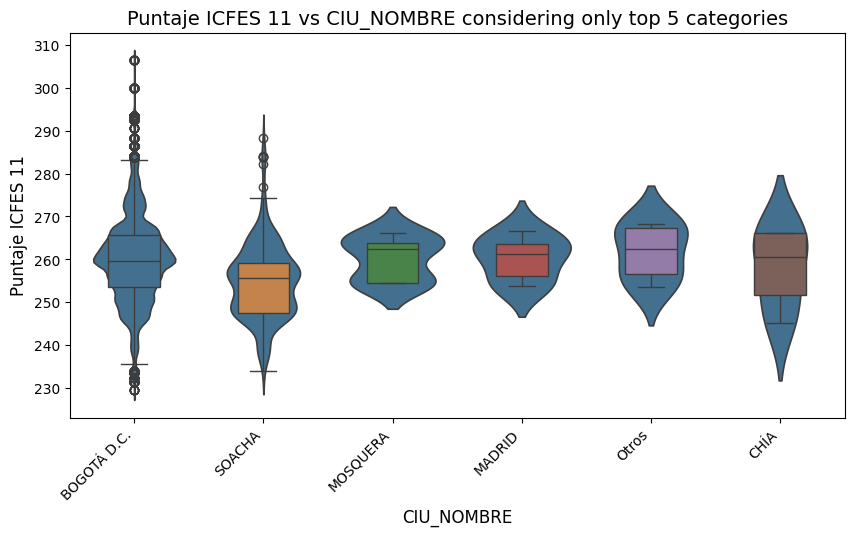

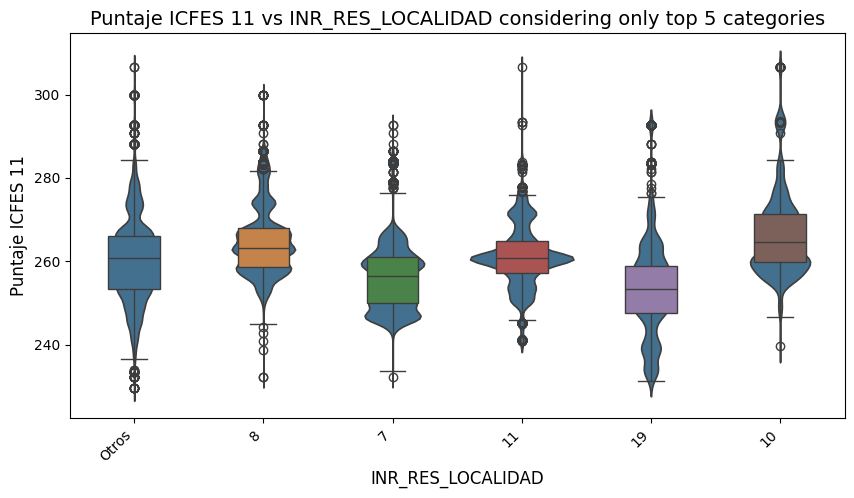

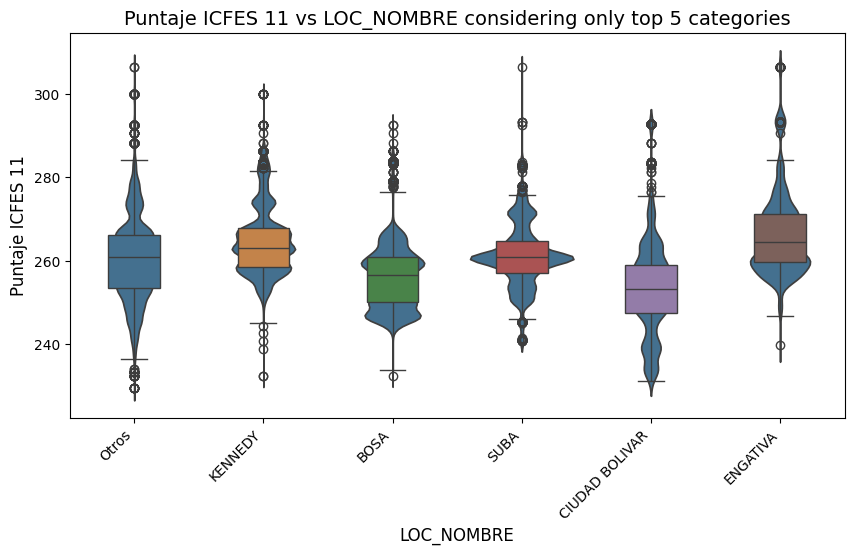

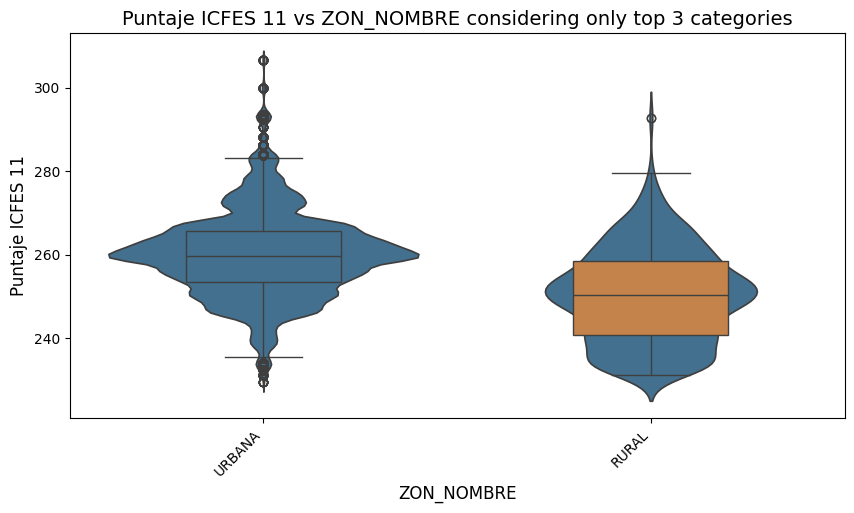

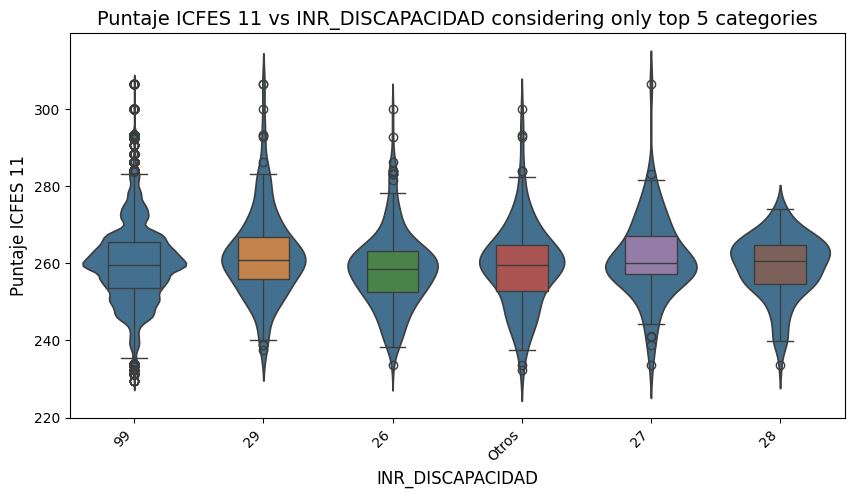

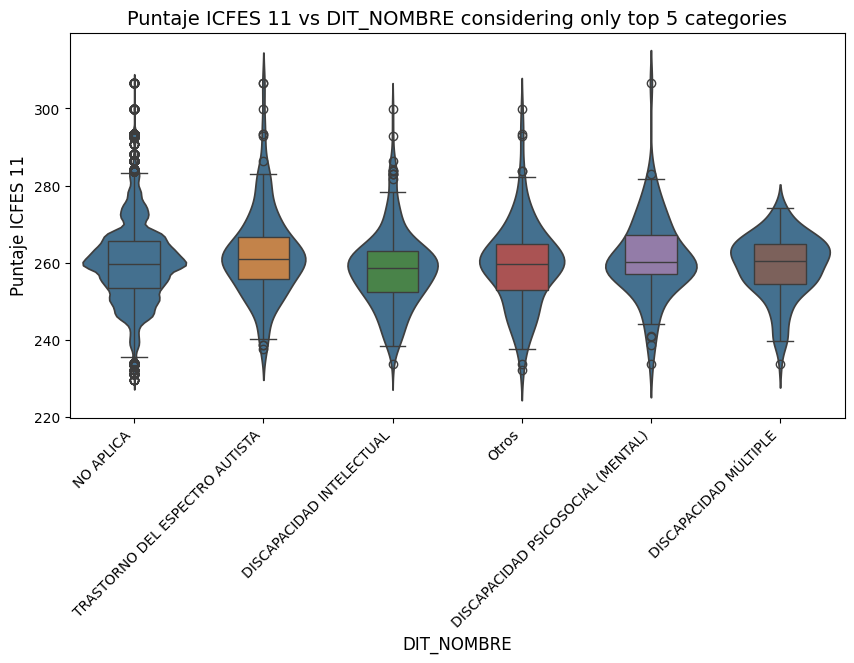

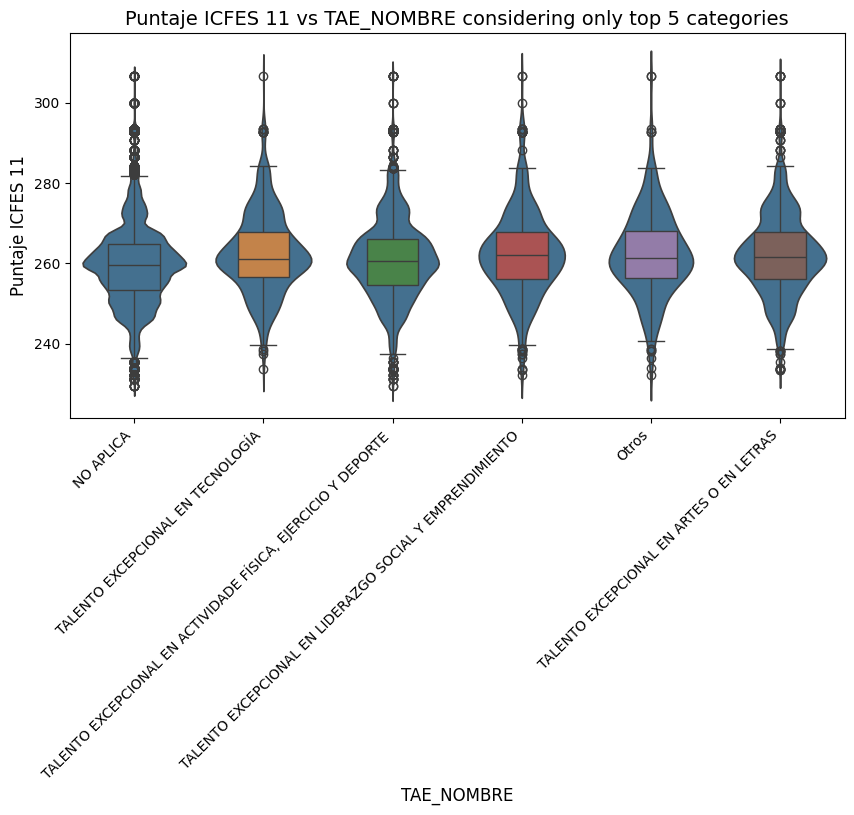

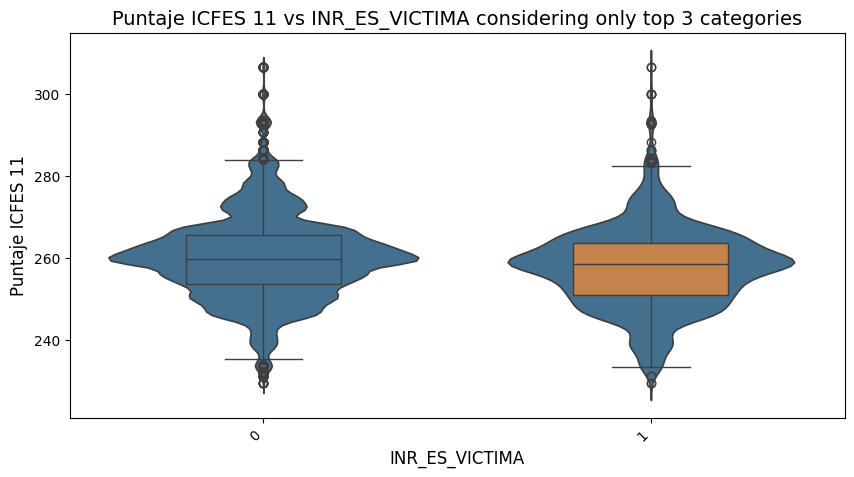

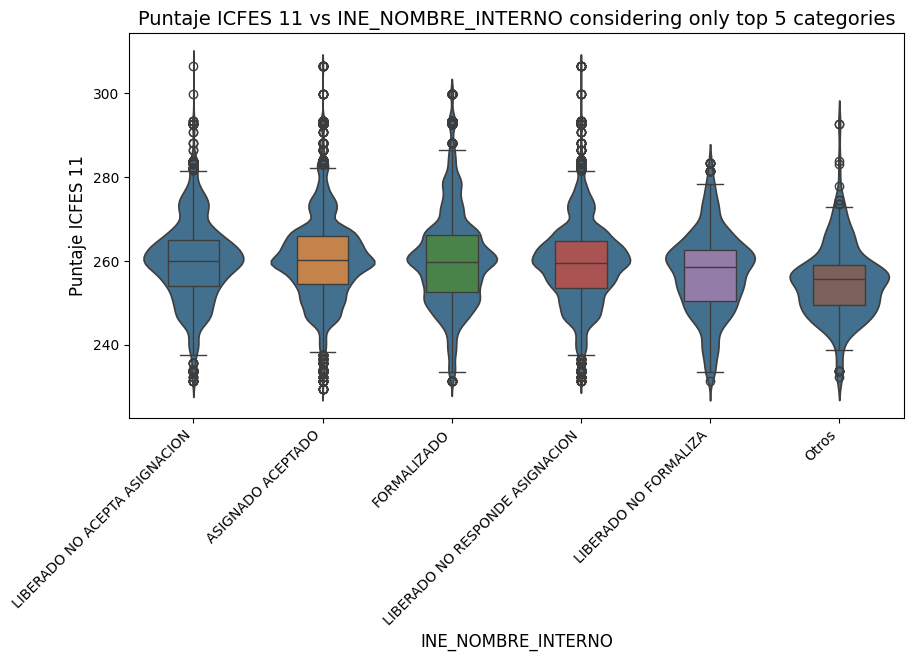

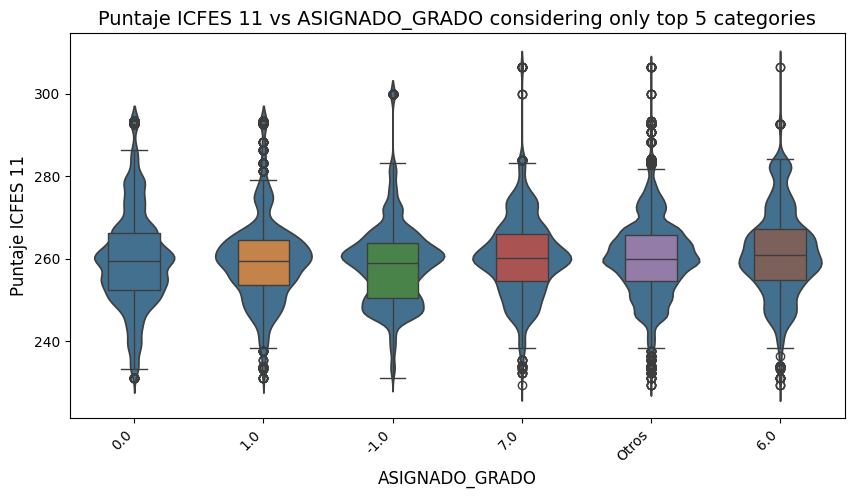

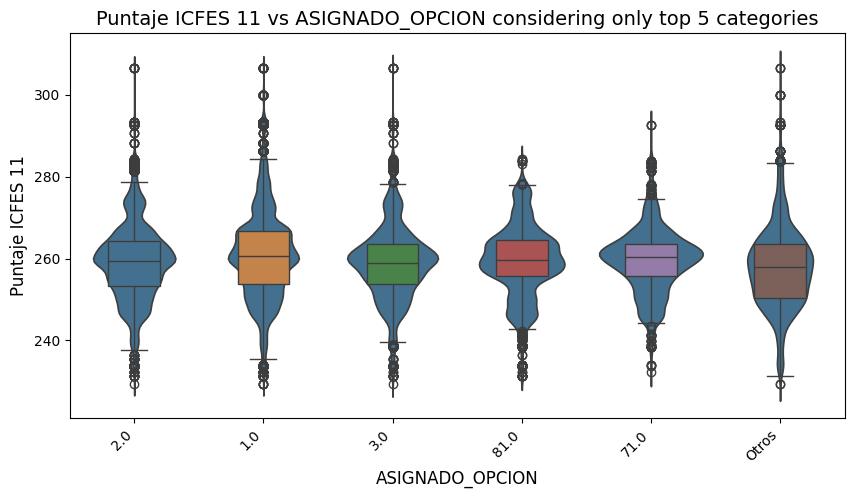

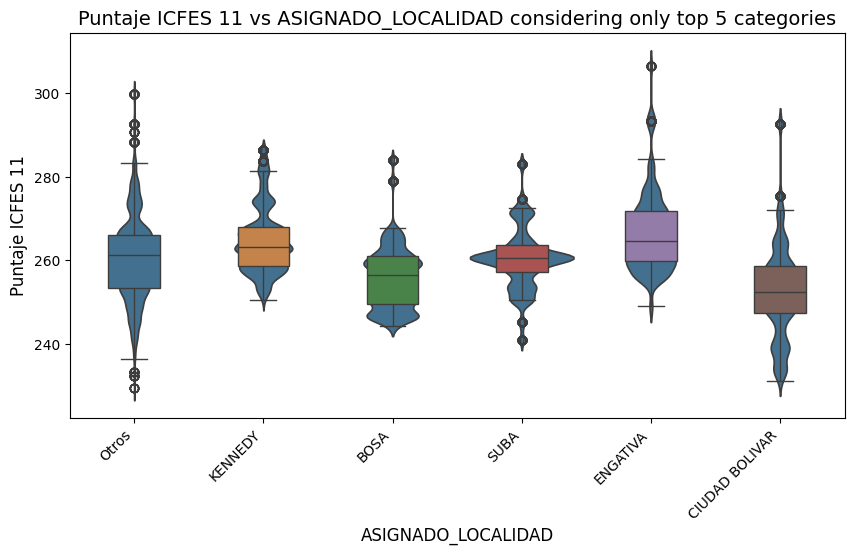

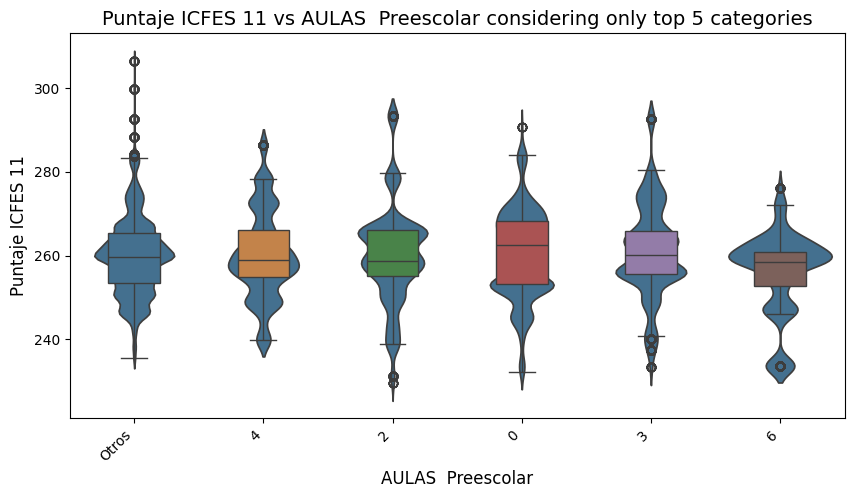

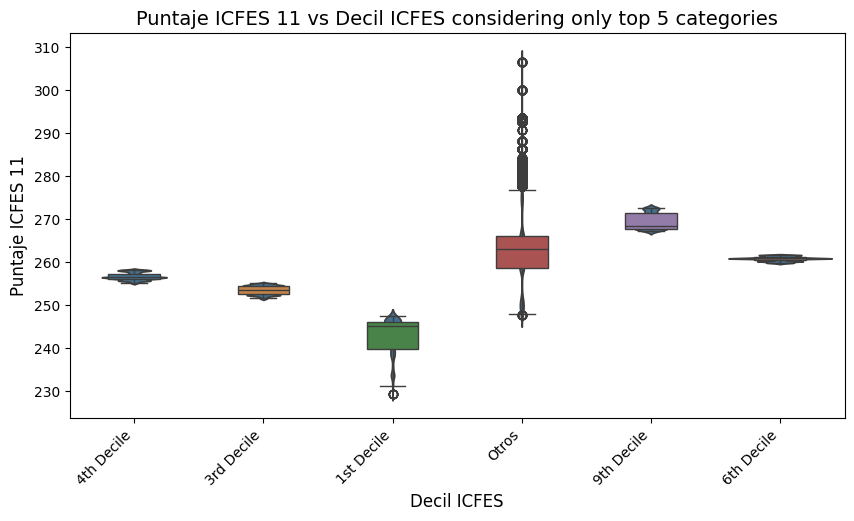

In [617]:
for col in df.columns:
    if (len(df[col].unique()) < 25) & (df[col].dtype != '<M8[ns]'):
        try:
            categories_vs_y(col, min(len(df[col].unique())+1,5), 'Puntaje ICFES 11')
        except:
            continue

#### 1.5.2 Análisis bivariado categoricas vs Capacidad

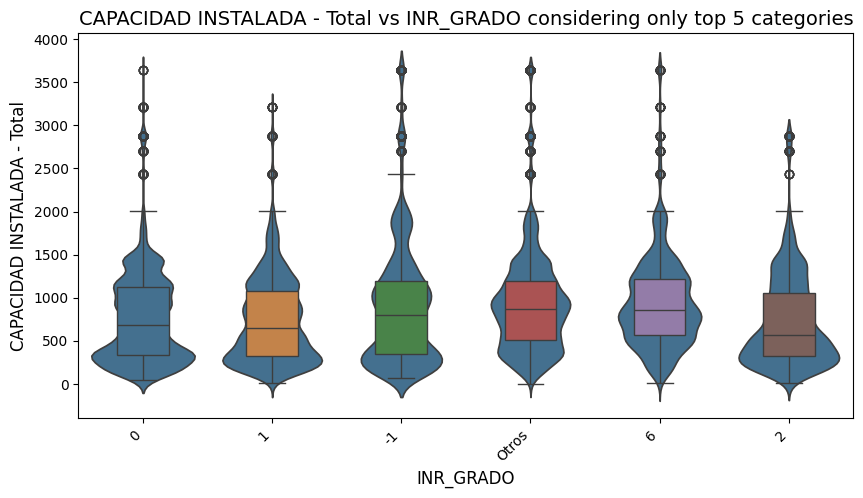

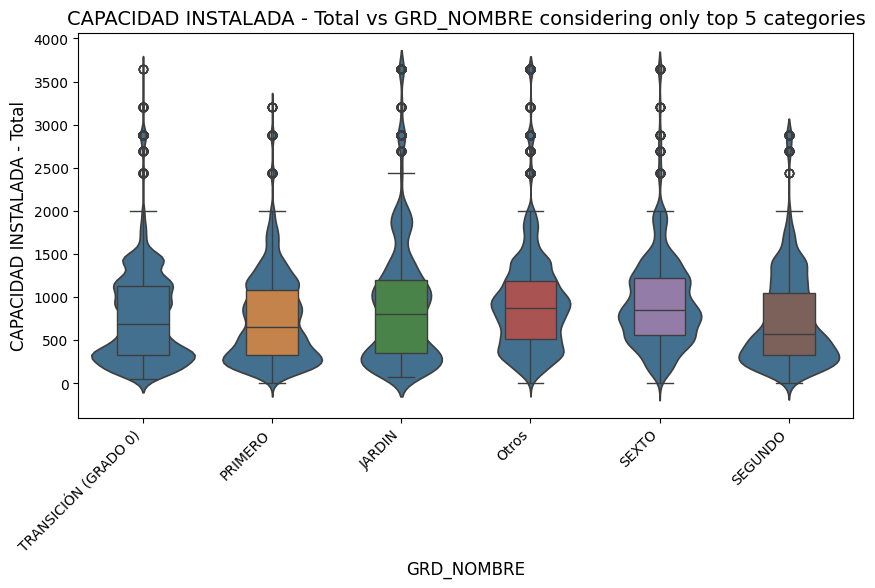

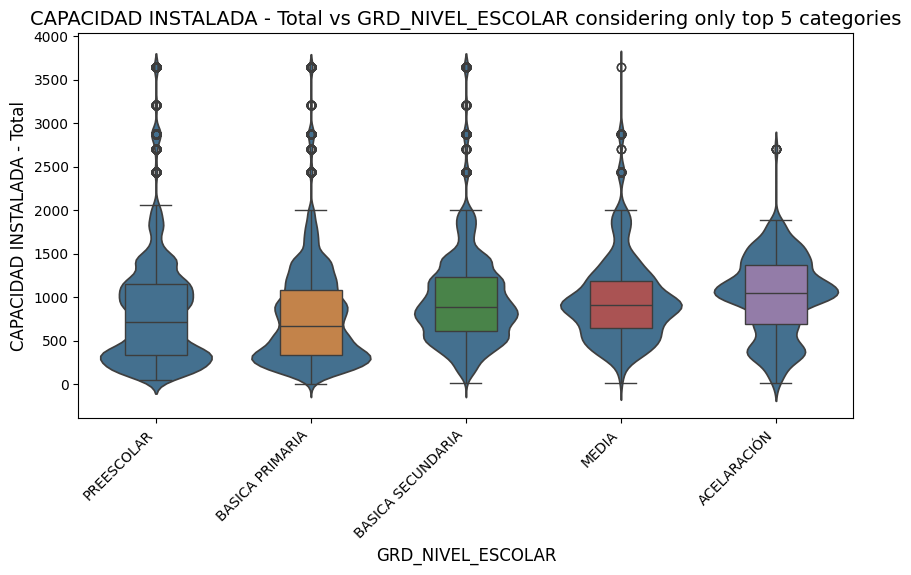

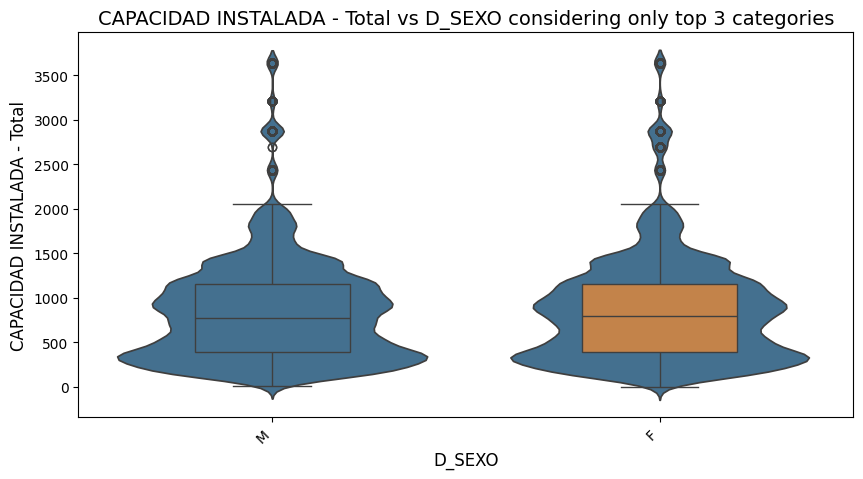

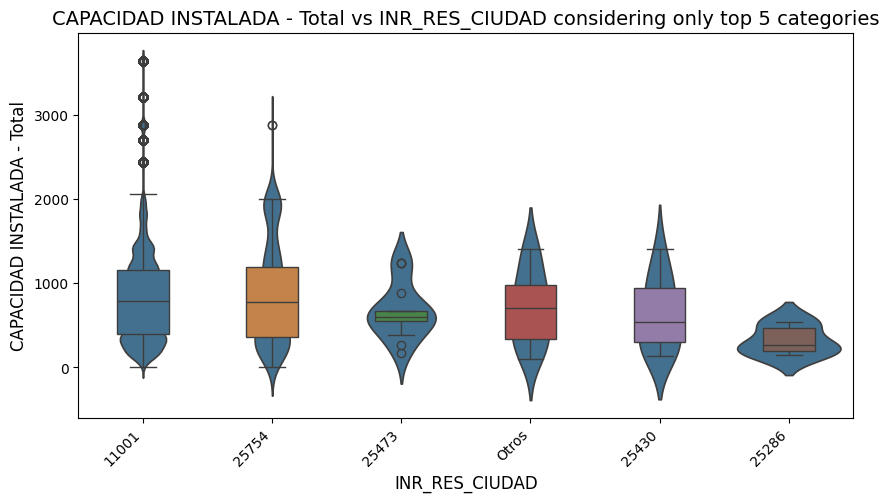

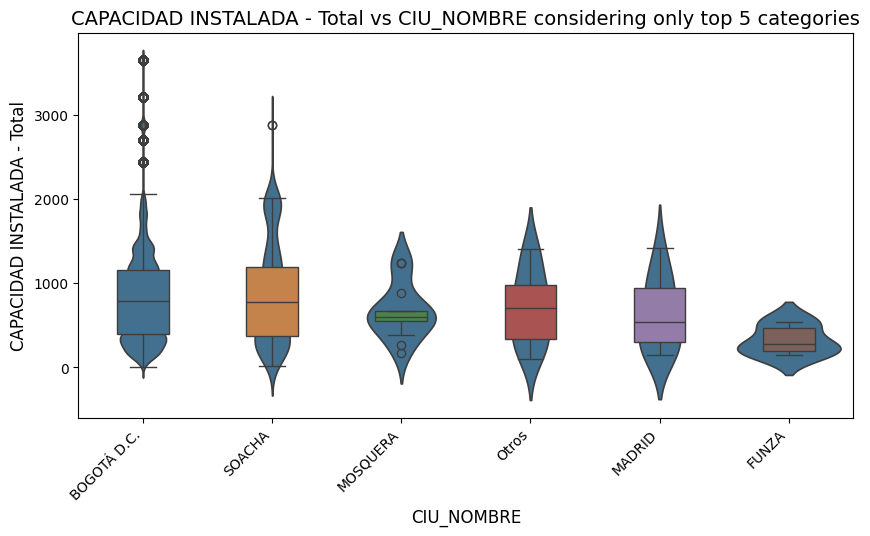

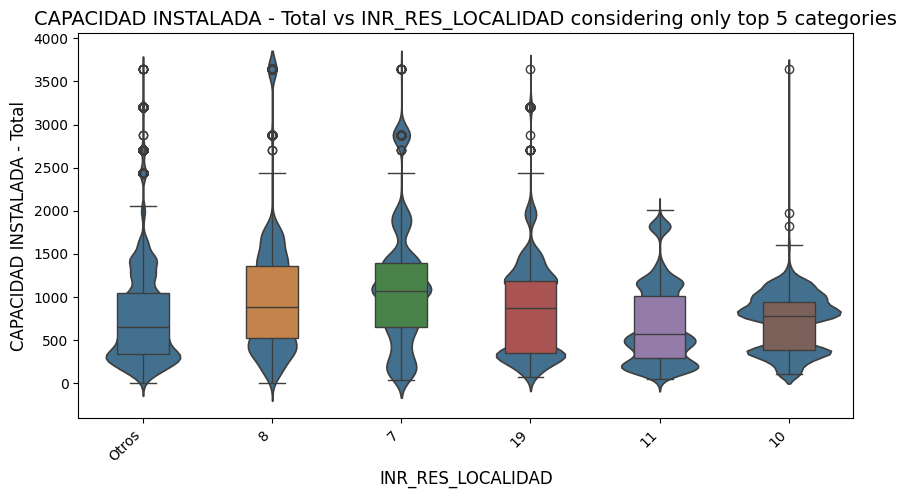

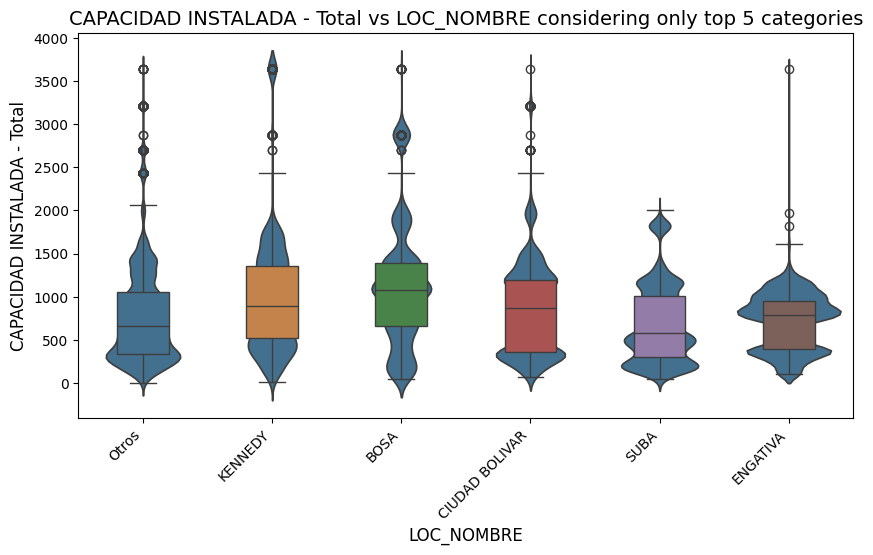

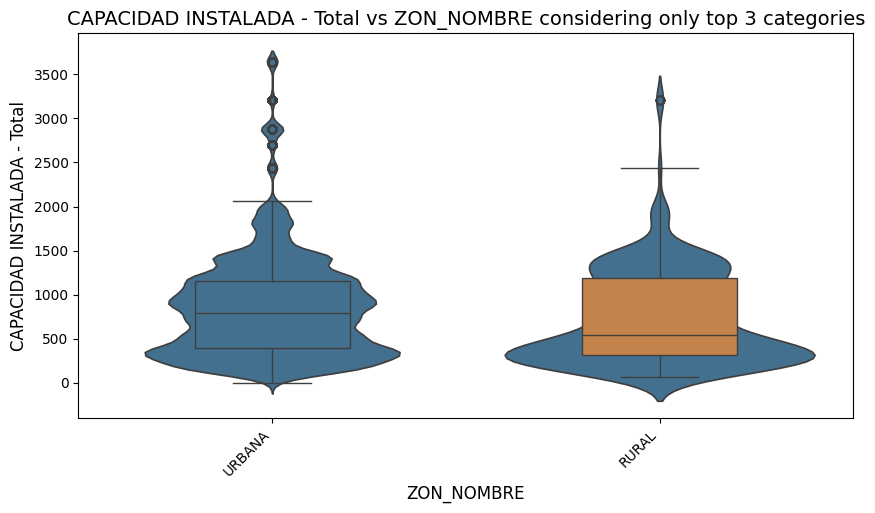

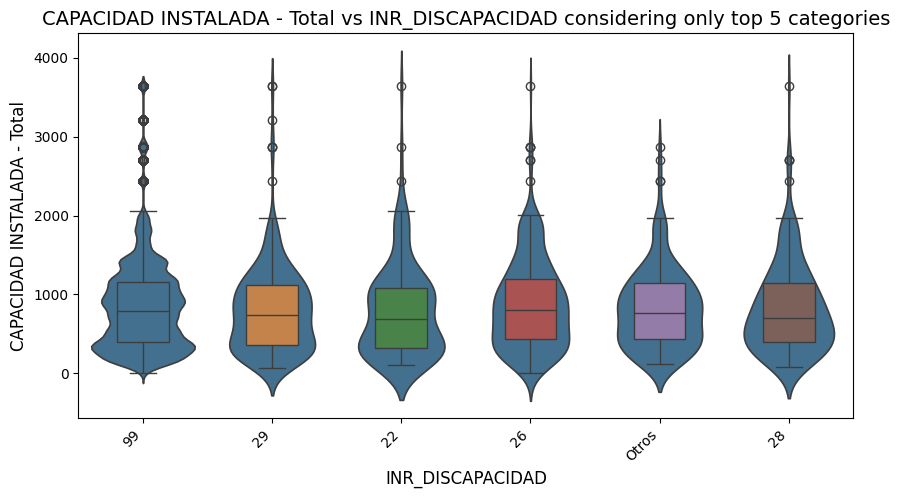

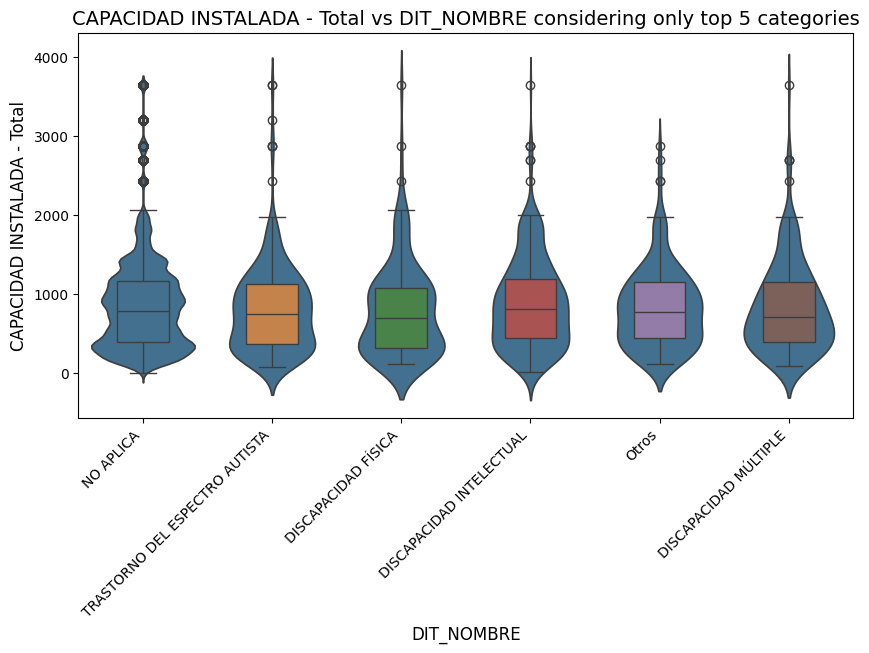

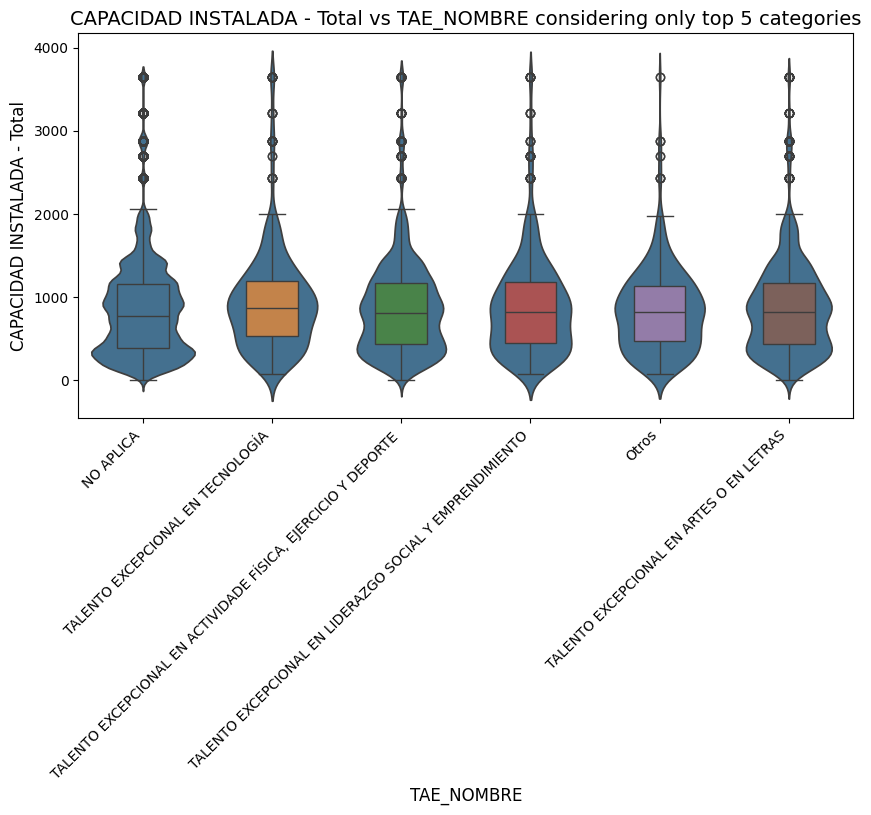

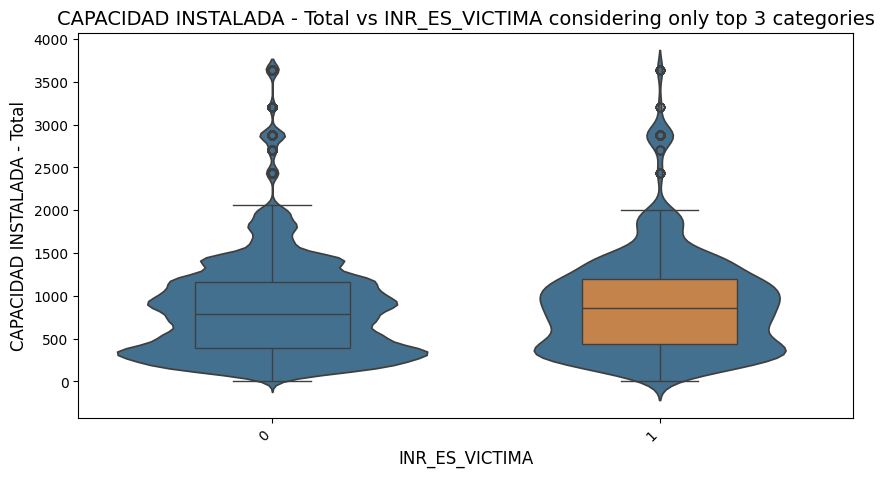

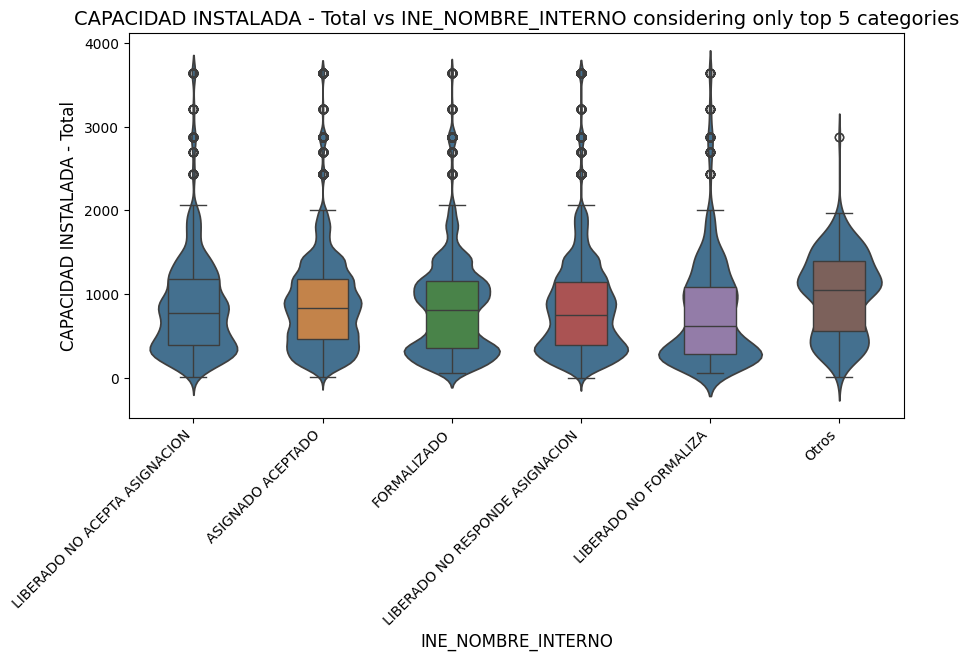

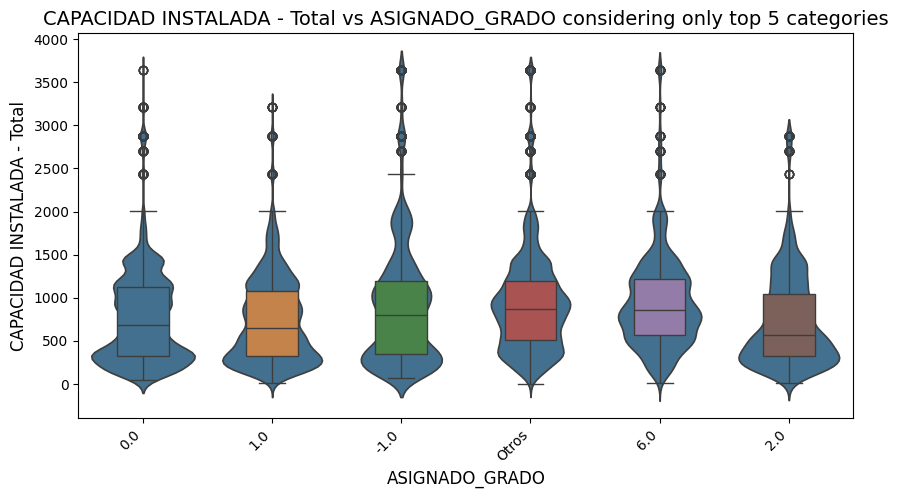

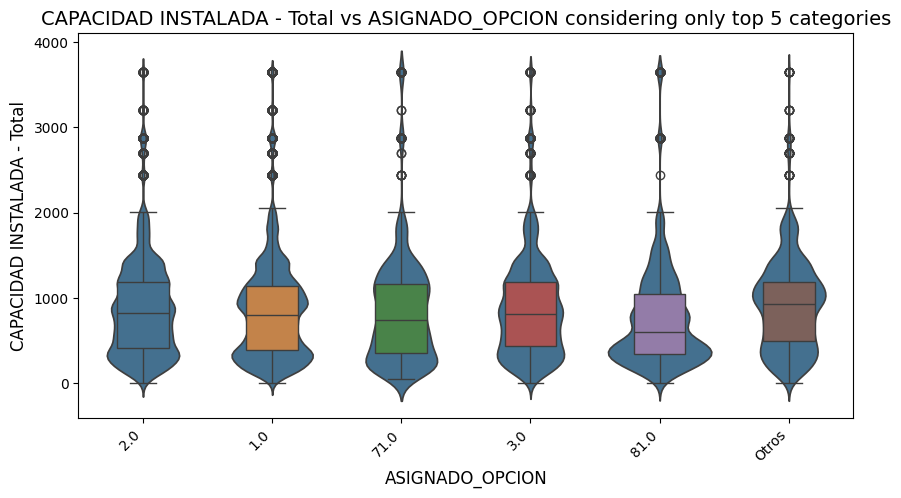

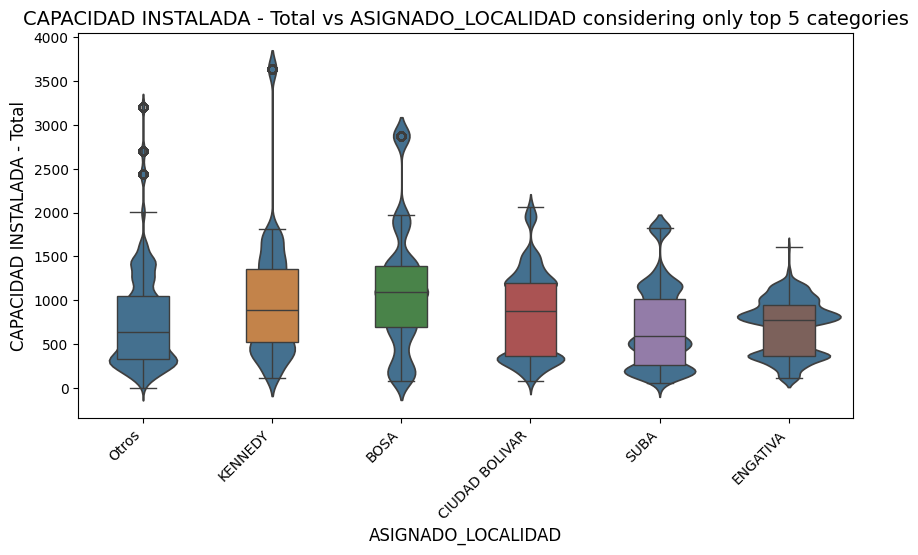

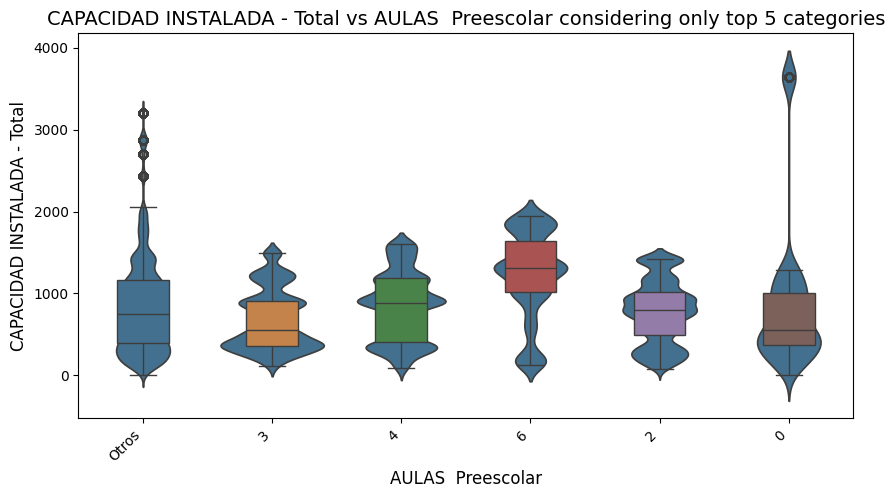

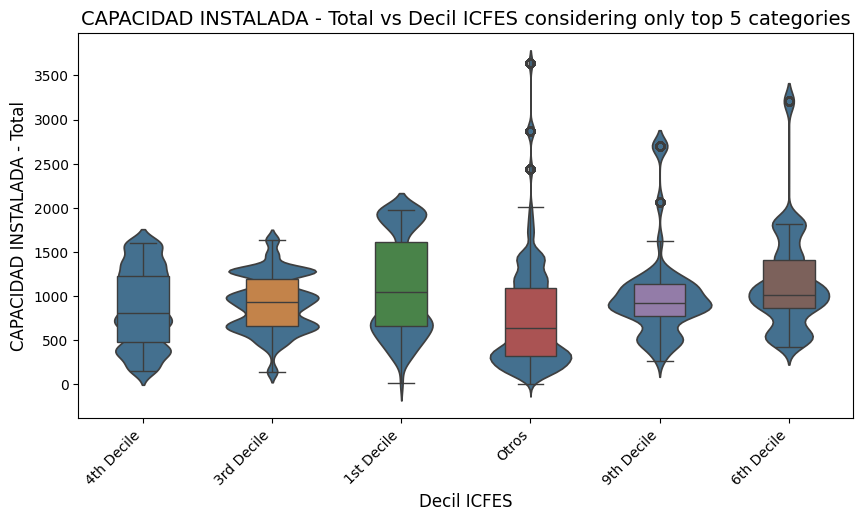

In [618]:
for col in df.columns:
    if (len(df[col].unique()) < 25) & (df[col].dtype != '<M8[ns]'):
        try:
            categories_vs_y(col, min(len(df[col].unique())+1,5), 'CAPACIDAD INSTALADA - Total')
        except:
            continue

#### 1.5.3 Análisis tablas de Frecuencia categorias vs Deciles ICFES

In [507]:
import warnings
warnings.filterwarnings("ignore")

In [584]:
def tablaFrecuenciasTopn(col, n, y):
    base = df[col].value_counts()[:n]
    suma_otros = df[col].value_counts()[n:].sum()
    s = pd.concat([base,pd.Series(  {'Otros':suma_otros})]).rename('counts').reset_index().rename(columns = {'index': col})
    d = df.groupby([col, y]).size().rename('Frecuencia').reset_index()
    d[col] = d[col].astype(s[col].dtype)
    m = d.merge(s, on = col, how= 'left')
    m.loc[m['counts'].isna(), col] = 'Otros'
    m = m.drop( columns = ['counts'])
    m[col] = m[col].astype('str')
    
    data = pd.pivot_table(m, values='Frecuencia',  index = [col], columns=y, aggfunc='sum')
    data = data / data.sum().sum()
    plt.figure(figsize=(10,4))
    plt.title(f'Tabla de frecuencias para {col} vs {y}')
    sns.heatmap(data, annot= True, fmt=".2%",cmap='Oranges')
    plt.xticks(rotation = 45, ha = 'right')
    plt.show()



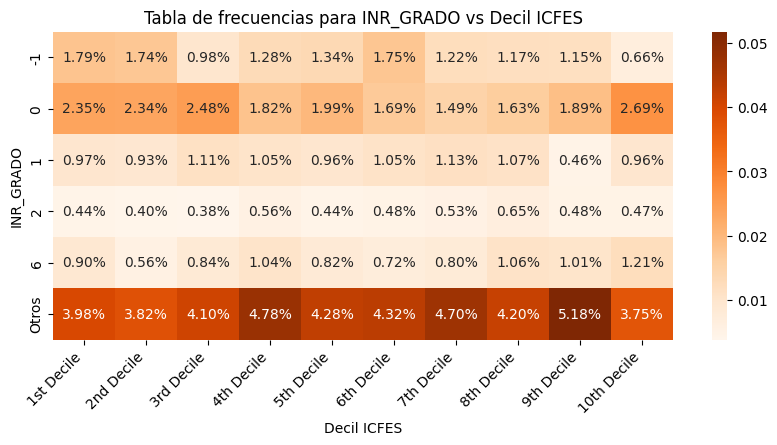

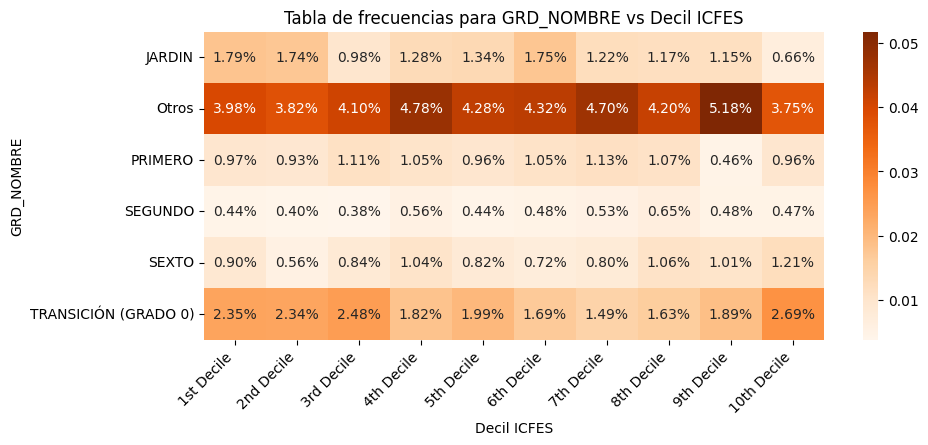

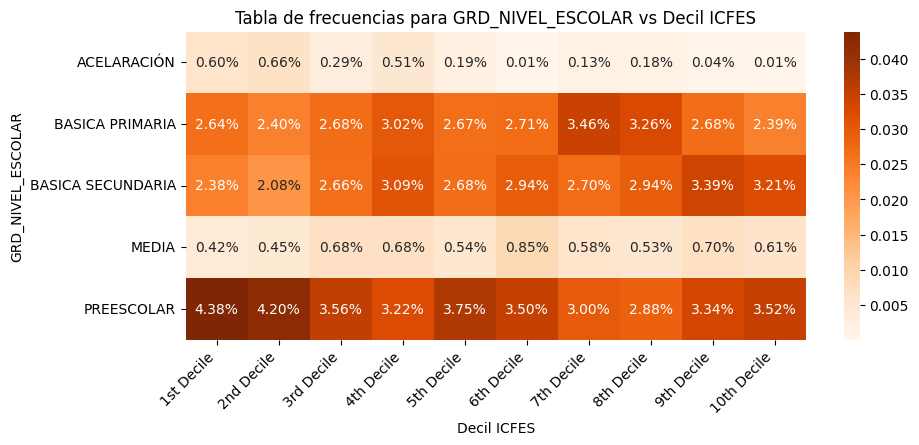

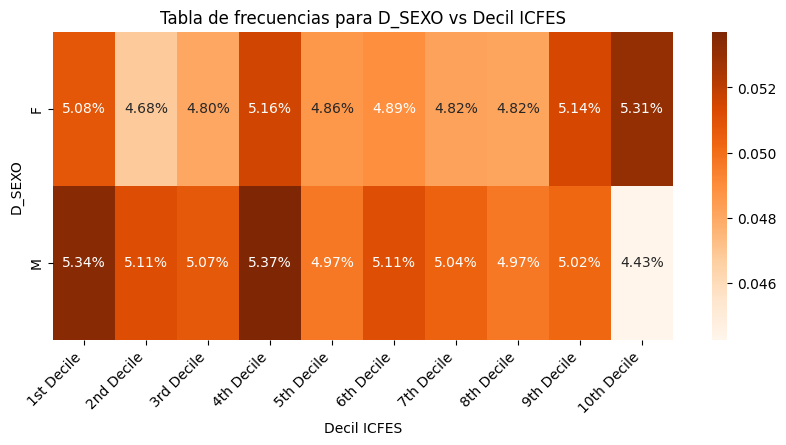

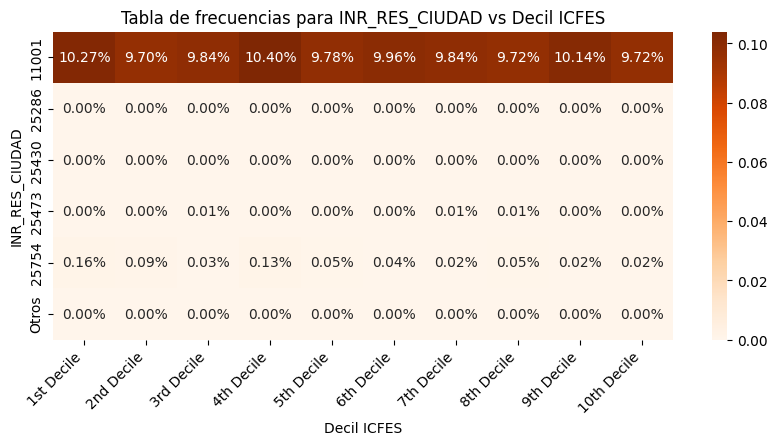

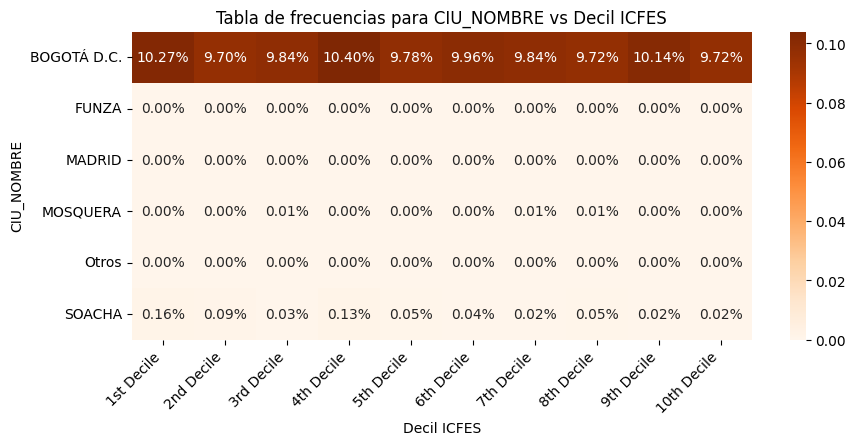

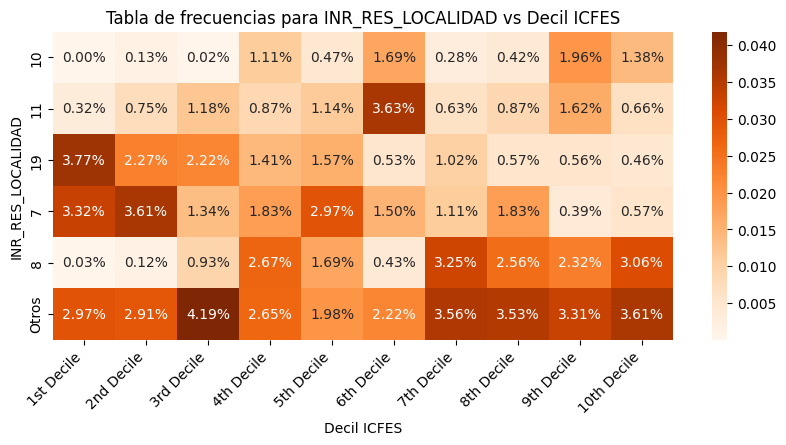

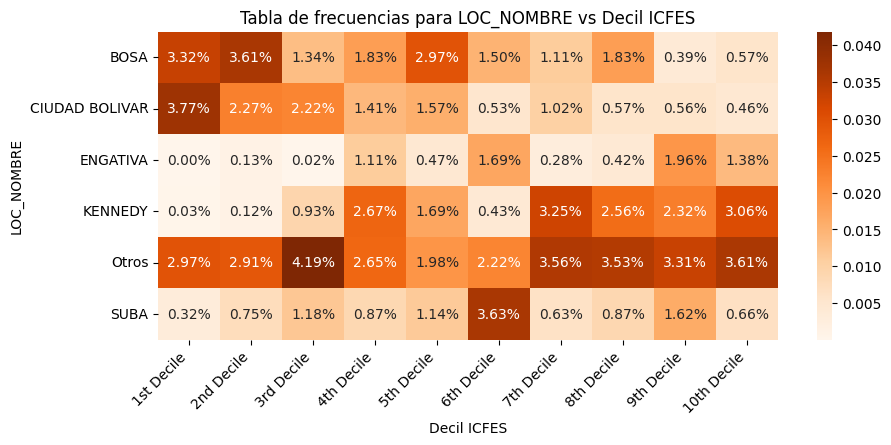

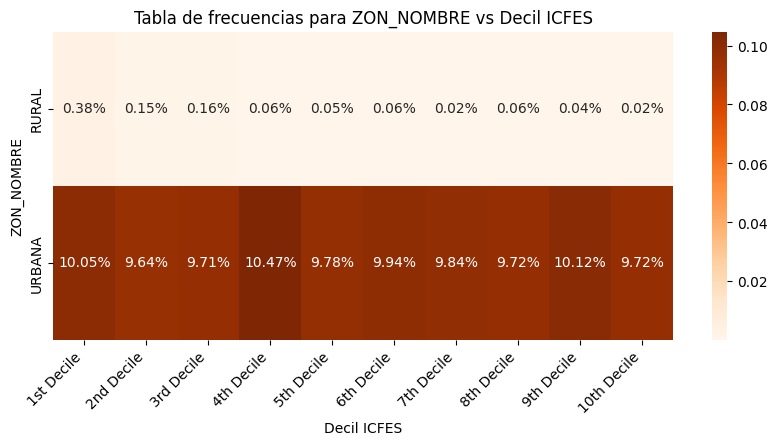

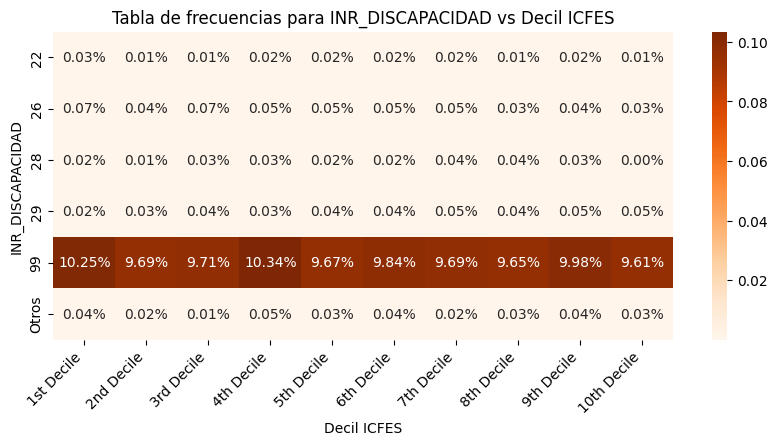

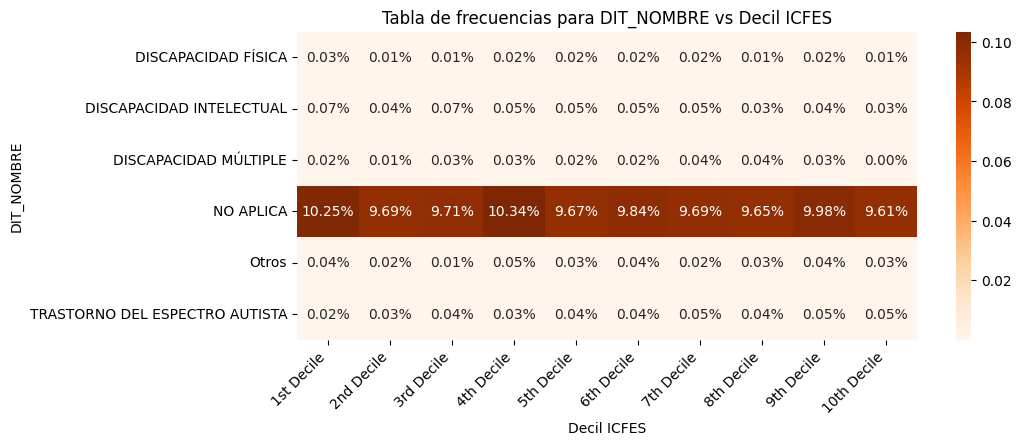

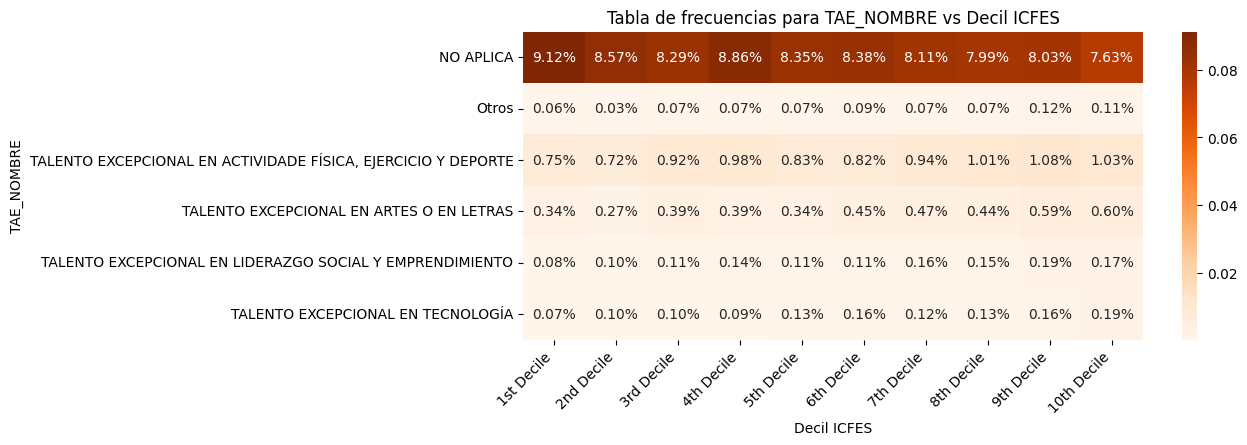

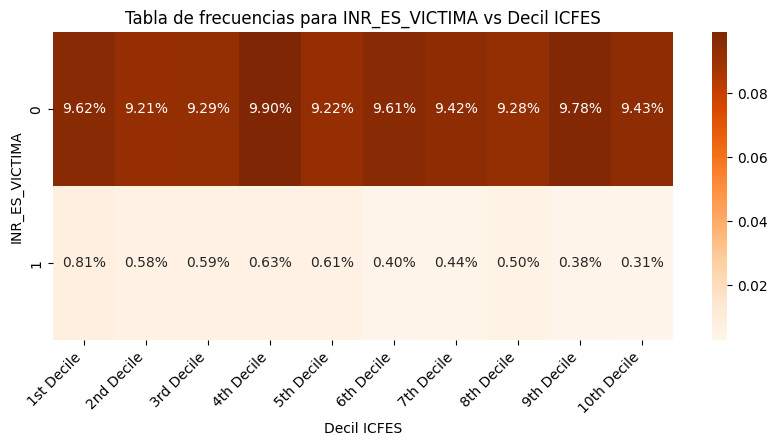

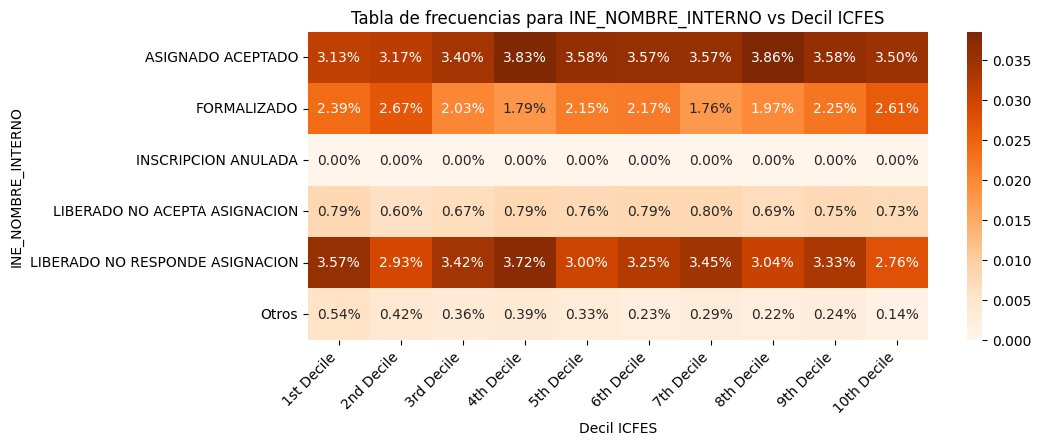

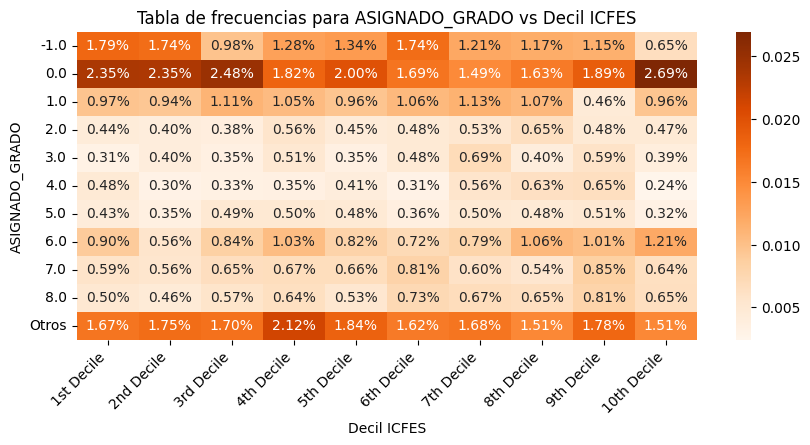

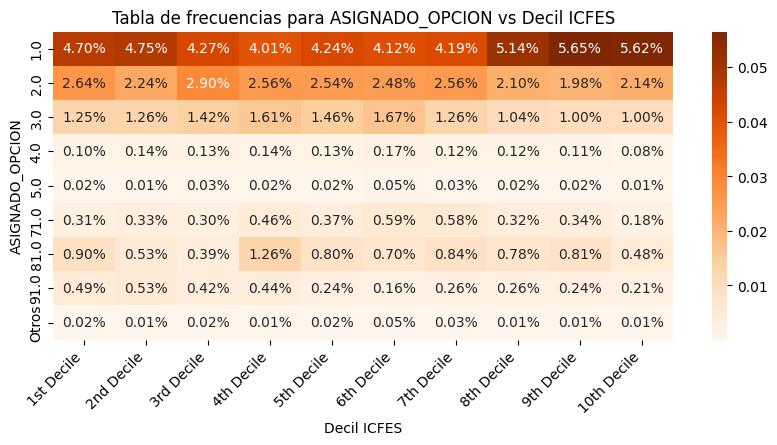

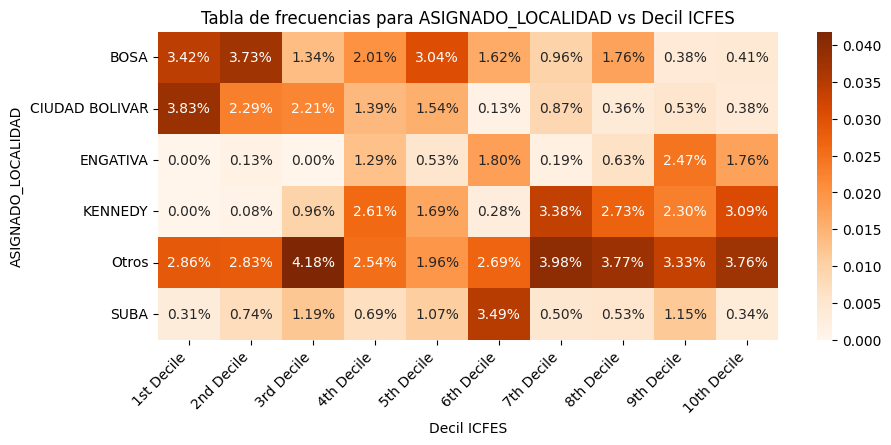

In [585]:
for col in df.columns:
    if (len(df[col].unique()) < 25) & (df[col].dtype != '<M8[ns]'):
        try:
            tablaFrecuenciasTopn(col, min(len(df[col].unique())+1,5), 'Decil ICFES')
        except:
            continue

#### 1.5.4 Análisis especifico

In [594]:
## Hisogramas
def historam(var):
    
    dataHist = df[var]
    n, bins, patches = plt.hist(x=dataHist, bins='auto', color='#98002E',alpha=0.7, rwidth=0.85)
    maxfreq = n.max()
    maxval = dataHist.min() + (dataHist.max() - dataHist.min())*0.69
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Rangos de datos Hearth Failure')
    plt.ylabel(f'{var}')
    plt.title(f'Distribution {var}')
    plt.text(maxval, maxfreq * 1.15, f'$\mu={round(dataHist.mean(),1)},$ $\sigma={round(dataHist.std(),1)}$')
    plt.text(maxval, maxfreq * 1.1, f'$Q_1={round(dataHist.quantile(q=0.25),1)},$ $Q_2={round(dataHist.quantile(q=0.5),1)},$ $Q_3={round(dataHist.quantile(q=0.75),1)}$')
    plt.text(maxval, maxfreq * 1.05, f'$Min={round(dataHist.min(),1)},$ $Max={round(dataHist.max(),1)}$')
    plt.ylim(ymax= maxfreq*1.3)
    plt.xlim(xmax= dataHist.max() * 1.1)

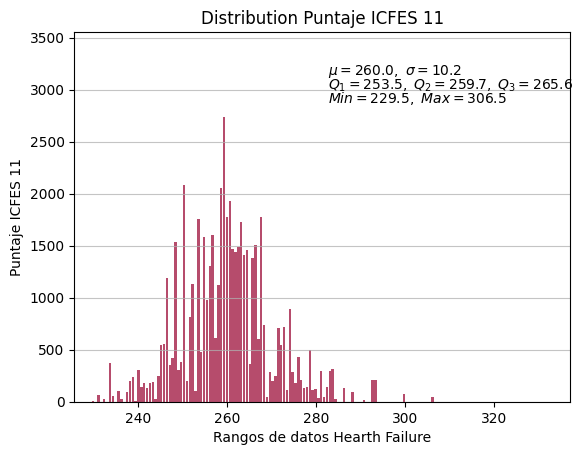

In [595]:
historam('Puntaje ICFES 11')

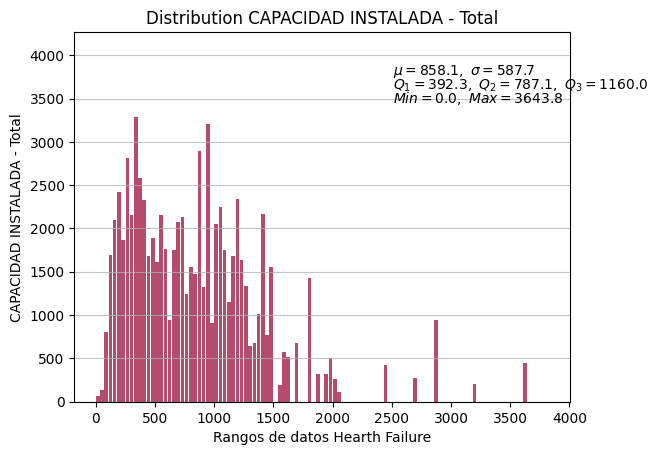

In [596]:
historam('CAPACIDAD INSTALADA - Total')

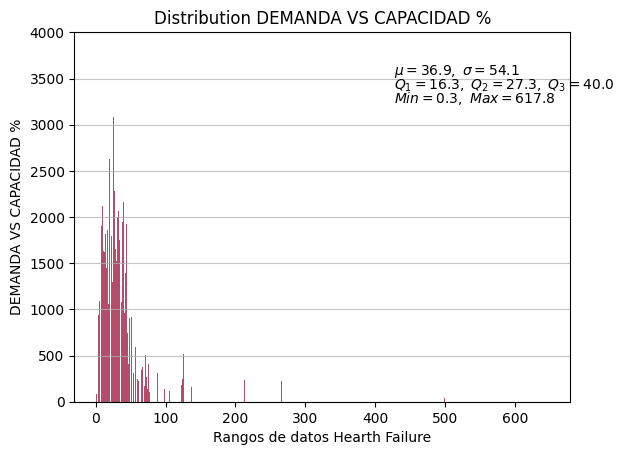

In [609]:
historam('DEMANDA VS CAPACIDAD %')

### 2 Propuesta Metodologica

## Requerimientos

In [409]:
import session_info

session_info.show(html=False)


-----
matplotlib          3.9.2
numpy               2.0.2
pandas              2.2.2
scipy               1.13.1
seaborn             0.13.2
session_info        1.0.0
sklearn             1.5.1
-----
IPython             8.18.1
jupyter_client      8.6.2
jupyter_core        5.7.2
jupyterlab          4.2.5
-----
Python 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
Windows-10-10.0.22631-SP0
-----
Session information updated at 2024-08-31 19:23
